In [1]:
import scanpy as sc
import os,re,sys
import pandas as pd
import numpy as np
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tspex
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# sns.set(style='white', font_scale=1)
# %config InlineBackend.figure_format = 'svg'
cmap = sns.blend_palette(['#5F6F94','#FFFAFA','#DD5353'],as_cmap=True)   ##4C6793
os.chdir('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans')

In [2]:
def make_index_unique(index: pd.Index, join: str = "-"):
    ##### exsample df_lungfish.index=make_index_unique(df_lungfish.index)
    """
    Makes the index unique by appending a number string to each duplicate index element:
    '1', '2', etc.

    If a tentative name created by the algorithm already exists in the index, it tries
    the next integer in the sequence.

    The first occurrence of a non-unique value is ignored.

    Parameters
    ----------
    join
         The connecting string between name and integer.

    Examples
    --------
    # >>> from anndata import AnnData
    # >>> adata = AnnData(np.ones((2, 3)), var=pd.DataFrame(index=["a", "a", "b"]))
    # >>> adata.var_names
    # Index(['a', 'a', 'b'], dtype='object')
    # >>> adata.var_names_make_unique()
    # >>> adata.var_names
    Index(['a', 'a-1', 'b'], dtype='object')
    """
    import warnings
    if index.is_unique:
        return index
    from collections import Counter

    values = index.values.copy()
    indices_dup = index.duplicated(keep="first")
    values_dup = values[indices_dup]
    values_set = set(values)
    counter = Counter()
    issue_interpretation_warning = False
    example_colliding_values = []
    for i, v in enumerate(values_dup):
        while True:
            counter[v] += 1
            tentative_new_name = v + join + str(counter[v])
            if tentative_new_name not in values_set:
                values_set.add(tentative_new_name)
                values_dup[i] = tentative_new_name
                break
            issue_interpretation_warning = True
            if len(example_colliding_values) < 5:
                example_colliding_values.append(tentative_new_name)

    if issue_interpretation_warning:
        warnings.warn(
            f"Suffix used ({join}[0-9]+) to deduplicate index values may make index "
            + "values difficult to interpret. There values with a similar suffixes in "
            + "the index. Consider using a different delimiter by passing "
            + "`join={delimiter}`"
            + "Example key collisions generated by the make_index_unique algorithm: "
            + str(example_colliding_values)
        )
    values[indices_dup] = values_dup
    index = pd.Index(values, name=index.name)
    return index

In [3]:
########## calculate the average expression value for same sample
def calculateAverage(data):
    cloumns_name=set([x.split('_')[0] for x in data.columns])
    for i in cloumns_name:
        data[i]=data[[x for x in data.columns if x.startswith(i)]].mean(axis=1)
    return data[cloumns_name]

###### calculate the tau value 
def calulateTau_value(data,methods="tou"):
    """
    :param average_expression: Whether to use the average expression value as input data
    :param data: this function was used to calculate  the DGEs by tau for same sameple and for cross sample by tspex
    :return:
    """
    import tspex
    expression_data = data.T
    if methods=="tou":
        tau_df = pd.DataFrame(columns=["gene","tau","rpkm_max","rpkm_mean","high_group","low_group"])
        count=0
        for gene in expression_data.columns.to_list():
            count+=1
            t=expression_data[gene]
            max_value = t.max()
            df_tmp =t.drop(t.idxmax())
            value2 = max_value*0.5
            df_high = t[t>value2]
            df_high.sort_values(ascending=False,inplace=True)
            mean_value = df_high.mean()
            h = df_high.index.to_list()
            df_low = t[t<=value2]
            l = df_low.index.to_list()
            tau =(1-df_tmp/max_value).sum()/(t.shape[0]-1)
            tmep_list = [gene,tau,max_value,mean_value, ",".join(h), ",".join(l)]
            info_df =pd.DataFrame(tmep_list,index=["gene","tau","rpkm_max","rpkm_mean","high_group","low_group"]).T
            tau_df=pd.concat([tau_df,info_df],ignore_index=True)
            # print(count)
        # # data.uns["tou_values_TPM"]=tau_df
        # data.uns["tou_values_TPM"] = {"data": tau_df.values,"columns": tau_df.columns.to_list(),"index": tau_df.index.tolist()}
        # data.uns["tou_values_TPM"]["data"]=data.uns["tou_values_TPM"]["data"].astype(str)
        return tau_df
    else:
        tso = tspex.TissueSpecificity(expression_data, 'spm', log=True)
        # data.layers["%s" %(methods)]=tso.tissue_specificity.T
        df_t =tso.tissue_specificity.T
        return df_t

#####fliter the tau value and select the high groups, especially for the tissues
def filterTau_value(data,min_value=0.8,key="liver",rank=2):
    df = data.copy()
    df["tau"]=df["tau"].astype(float)
    df["rpkm_max"]=df["rpkm_max"].astype(float)
    df = df[(df["tau"]>=min_value) & (df["rpkm_max"]>=1)]
    df = df[df["high_group"].str.contains(key)]
    def function(x):
        m = x["high_group"].split(",")
        c = m.index(key)+1
        return c
    df["rank"]=df.apply(function,axis=1)
    df=df[df['rank']<=rank]
    return df
    # df.filter(lambda x:x["high_group"])

In [4]:
def gene2Name():
    dic2 = {}
    path='H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/04.gene2names'
    for i in os.listdir(path):
        if i.endswith('.tsv'):
            dic1 = {}
            sp = i.split('.')[0]
            file =open(path+'/'+i,'r')
            for line in file:
                line = line.strip().split('\t')
                dic1[line[0]] = line[1]
                dic2[sp] = dic1
            file.close()
        else:
            continue
    return dic2

In [5]:
df_lamprey=pd.read_csv('lamprey.TPM.all2',sep='\t',header=0,index_col=0)
# df_dogshark=pd.read_csv('dogshark.fpkm.all',sep='\t',header=0,index_col=0)
df_lungfish=pd.read_csv('lungfish.TPM.all',sep='\t',header=0,index_col=0)
df_bichir=pd.read_csv('bichir.fpkm.all',sep='\t',header=0,index_col=0)
df_frog=pd.read_csv('frog.TPM.all2',sep='\t',header=0,index_col=0)
df_frog.index = df_frog.index.str.upper()
df_lizard=pd.read_csv('lizard.fpkm.all',sep='\t',header=0,index_col=0)
df_human=pd.read_csv('human.fpkm.all',sep='\t',header=0,index_col=0)
df_mouse=pd.read_csv('mouse.fpkm.all',sep='\t',header=0,index_col=0)
df_chicken=pd.read_csv('chicken_TPM.all',sep='\t',header=0,index_col=0)
df_elephantshark = pd.read_csv('elephantShark.RPKM.txt',sep='\t',header=0,index_col=0)
df_yaoyu = pd.read_csv('yaoyu.tpm.all',sep='\t',header=0,index_col=0)
df_dogshawk = pd.read_csv('dogshark.tpm.all',sep='\t',header=0,index_col=0)
df_hagfish = pd.read_csv('hagfish.tpm.all',sep='\t',header=0,index_col=0)
df_stickleback=pd.read_csv('stickleback.TPM.all',sep='\t',header=0,index_col=0)
df_turbot=pd.read_csv('turtot.tpm.all',sep='\t',header=0,index_col=0)
df_zebrafish=pd.read_csv('zebrafish.tpm.all',sep='\t',header=0,index_col=0)
df_lengpigui=pd.read_csv('lengpigui.TPM.all',sep='\t',header=0,index_col=0)
df_lancelet=pd.read_csv('06.lancelet/lancelet.all.tpm',sep='\t',header=0,index_col=0)
df_xenopus=pd.read_csv('Xenopus_TPM.txt',sep='\t',header=0,index_col=0)

In [9]:
sp_list= [df_lamprey,df_lungfish,df_bichir,df_frog,df_lizard,df_elephantshark,df_yaoyu,df_dogshawk,df_hagfish,df_stickleback,df_zebrafish,df_lengpigui,df_chicken]
count=0
for i in sp_list:
    count+=i.shape[1]
print(count)

411


In [10]:
count+df_human.shape[1]*3 +df_mouse.shape[1]*3

525

In [11]:
df_lamprey.drop(columns=['liver_1','liver_3','liver_4'],inplace=True)

In [6]:
lancelet=calculateAverage(df_lancelet)

In [12]:
lancelet.loc['BL21667']

primary dorsal nerve cord    29.400861
egg cell                      0.157466
muscle tissue                 2.370023
neurula embryo                1.515067
hepatic cecum                 7.442526
gastrula                      0.346144
skin epidermis                0.806282
pharyngeal slit               9.406877
ovary                         0.426480
embryo                        2.753770
larva                        34.676491
oral cirrus                   6.329650
testis                        1.355160
digestive tract              47.541149
blastula                      0.352677
Name: BL21667, dtype: float64

In [9]:
tau_lancelet=calulateTau_value(lancelet)

In [10]:
tau_lancelet

,gene,tau,rpkm_max,rpkm_mean,high_group,low_group
0,BL00000,0.563116,37.5591,27.8445,"pharyngeal slit,neurula embryo,primary dorsal ...","blastula,hepatic cecum,muscle tissue,oral cirr..."
1,BL00001,0.966023,12.2242,12.2242,primary dorsal nerve cord,"pharyngeal slit,blastula,hepatic cecum,neurula..."
2,BL00002,0.814639,164.586,125.617,"blastula,embryo","pharyngeal slit,hepatic cecum,neurula embryo,l..."
3,BL00003,0.958234,152.892,152.892,skin epidermis,"pharyngeal slit,blastula,hepatic cecum,neurula..."
4,BL00004,0.811929,254.148,178.18,"skin epidermis,primary dorsal nerve cord,oral ...","pharyngeal slit,blastula,hepatic cecum,neurula..."
...,...,...,...,...,...,...
35950,BL97479,0.903183,27.0805,27.0805,egg cell,"pharyngeal slit,blastula,hepatic cecum,neurula..."
35951,BL97480,0.903118,93.6679,93.6679,egg cell,"pharyngeal slit,blastula,hepatic cecum,neurula..."
35952,BL97481,0.686562,7.01535,5.96943,"embryo,digestive tract,hepatic cecum,larva","pharyngeal slit,blastula,neurula embryo,muscle..."
35953,BL97482,0.89029,10.7771,8.55791,"hepatic cecum,digestive tract","pharyngeal slit,blastula,neurula embryo,larva,..."


In [267]:
lamprey=calculateAverage(df_lamprey)
# dogshark=calculateAverage(df_dogshark)
lungfish=calculateAverage(df_lungfish)
bichir=calculateAverage(df_bichir)
frog=calculateAverage(df_frog)
lizard=calculateAverage(df_lizard)
chicken=calculateAverage(df_chicken)
hagfish=calculateAverage(df_hagfish)
elephantshark=pd.read_csv('elephantShark.RPKM.txt',sep='\t',header=0,index_col=0)   ###### the average expression value for elphantshark has been calculated
dogshark=calculateAverage(df_dogshawk)
human=pd.read_csv('./human.TPM.tsv',sep='\t',header=0,index_col=0)  ###### the average expression value for human has been calculated
mouse=pd.read_csv('./mouse.fpkm.all',sep='\t',header=0,index_col=0)   ###### the average expression value for mouse has been calculated
Greenlizard = pd.read_csv('./Greenlizard.FPKM.txt',sep='\t',header=0,index_col=0)  ###### the average expression value for human has been calculated
stickleback=calculateAverage(df_stickleback)
turbot=calculateAverage(df_turbot)
zebrafish=calculateAverage(df_zebrafish)
yaoyu=calculateAverage(df_yaoyu)
lengpigui=calculateAverage(df_lengpigui)
lancelet=calculateAverage(df_lancelet)
xenopus=calculateAverage(df_xenopus)

In [8]:
tau_lamprey=calulateTau_value(lamprey)
tau_lungfish=calulateTau_value(lungfish)
tau_bichir=calulateTau_value(bichir)
tau_frog=calulateTau_value(frog)
tau_lizard=calulateTau_value(lizard)
tau_human=calulateTau_value(human)
tau_mouse=calulateTau_value(mouse)
tau_chicken=calulateTau_value(chicken)
tau_elephantshark=calulateTau_value(elephantshark)
tau_Greenlizard=calulateTau_value(Greenlizard)
tau_hagfish=calulateTau_value(hagfish)

In [44]:
tau_zebrafish=calulateTau_value(zebrafish)
tau_stickleback=calulateTau_value(stickleback)
tau_turbot=calulateTau_value(turbot)
tau_lengpigui=calulateTau_value(lengpigui)
tau_yaoyu=calulateTau_value(yaoyu)
tau_dogshark=calulateTau_value(dogshark)

In [9]:
tau_lamprey['name']=tau_lamprey['gene'].map(gene2Name()['lamprey'])
tau_lungfish['name']=tau_lungfish['gene'].map(gene2Name()['lungfish'])
tau_bichir['name']=tau_bichir['gene'].map(gene2Name()['bichir'])
tau_frog['name']=tau_frog['gene'].map(gene2Name()['frog'])
# tau_lizard['name']=tau_lizard['gene'].map(gene2Name()['lizard'])
tau_human['name']=tau_human['gene'].map(gene2Name()['human'])
tau_mouse['name']=tau_mouse['gene'].map(gene2Name()['mouse'])
tau_chicken['name']=tau_chicken['gene'].map(gene2Name()['chicken'])
tau_elephantshark['name']=tau_elephantshark['gene'].map(gene2Name()['elephantshark'])
tau_Greenlizard['name']=tau_Greenlizard['gene'].map(gene2Name()['Greenlizard'])
tau_hagfish['name']=tau_hagfish['gene'].map(gene2Name()['hagfish'])

In [10]:
fiflter_tau_lamprey=filterTau_value(tau_lamprey)
fiflter_tau_lungfish=filterTau_value(tau_lungfish)
fiflter_tau_bichir=filterTau_value(tau_bichir)
fiflter_tau_frog=filterTau_value(tau_frog)
fiflter_tau_human=filterTau_value(tau_human)
fiflter_tau_mouse=filterTau_value(tau_mouse)
fiflter_tau_chicken=filterTau_value(tau_chicken)
fiflter_tau_elephantshark=filterTau_value(tau_elephantshark)
fiflter_tau_Greenlizard=filterTau_value(tau_Greenlizard)
# fiflter_tau_lizard=filterTau_value(tau_lizard)
fiflter_tau_hagfish=filterTau_value(tau_hagfish)

In [11]:
gene_name = {}
gene_name = gene2Name()

In [12]:
tau_info = {'lamprey':fiflter_tau_lamprey,'elephantshark':fiflter_tau_elephantshark,'lungfish':fiflter_tau_lungfish, 'Greenlizard':fiflter_tau_Greenlizard,
            'bichir':fiflter_tau_bichir,'frog':fiflter_tau_frog,'human':fiflter_tau_human,'mouse':fiflter_tau_mouse,'chicken':fiflter_tau_chicken,'hagfish':fiflter_tau_hagfish}

In [15]:
genes=[]
for i in tau_info.keys():
    tau_info[i]["gene_name"]=tau_info[i]["gene"].map(gene_name[i])
    genes=genes+list(set(tau_info[i]["gene_name"].to_list()))

In [28]:
tau_info['hagfish'].to_csv('hagfish.tau.txt',sep='\t',index=False)

In [33]:
writer=pd.ExcelWriter('tau_value.xlsx')
sheet_name = tau_info.keys()
for sheetName in sheet_name:
    tau_info[sheetName].to_excel(writer,sheet_name=sheetName)
writer.save()

In [18]:
import numpy as np
import math
m= set(genes)
common_DEG=[]
for x in m:
    if genes.count(x) >= 9:
        if str(x)=='nan':
            continue
        else:
            a= str(x)
            common_DEG.append(a)
            print(a)
            # print(f'{x}:{genes.count(x)}')
# human_DEG=tau_info['human'][tau_info["human"]["gene_name"].isin(list(common_DEG))]
# frog_DEG=tau_info['frog'][tau_info["frog"]["gene_name"].isin(list(common_DEG))]
# mouse_DEG=tau_info['mouse'][tau_info["mouse"]["gene_name"].isin(list(common_DEG))]
# lamprey_DEG=tau_info['lamprey'][tau_info["lamprey"]["gene_name"].isin(list(common_DEG))]
# elephantshark_DEG=tau_info['elephantshark'][tau_info["elephantshark"]["gene_name"].isin(list(common_DEG))]
# lungfish_DEG=tau_info['lungfish'][tau_info["lungfish"]["gene_name"].isin(list(common_DEG))]
# bichir_DEG=tau_info['bichir'][tau_info["bichir"]["gene_name"].isin(list(common_DEG))]
# Greenlizard_DEG=tau_info['Greenlizard'][tau_info["Greenlizard"]["gene_name"].isin(list(common_DEG))]
# chicken_DEG=tau_info['chicken'][tau_info["chicken"]["gene_name"].isin(list(common_DEG))]
# hagfish_DEG=tau_info['hagfish'][tau_info["hagfish"]["gene_name"].isin(list(common_DEG))]


ITIH2
HABP2
PAH
HAO1
F2
ITIH3
HAL
F9
VTN
AMBP
SORD
FGB
KNG1
HGD
SERPIND1
SERPINF2
FGA
HAAO
CP
PLG
HPD
C3
F7
TDO2
F10
FGG
CFI


In [ ]:
tau_info['chicken'].shape

In [14]:
keys = []
for x in gene_name.keys():
    for y in gene_name[x].keys():
        if gene_name[x][y] == 'F9':
            keys.append(y)
print(keys)

['BIRCIR002497', 'BIRCIR004540', 'F9', 'PRE07469', 'eShark103178220', 'eShark103179434', 'eShark103186822', 'FROG000553', 'lizard100563567', 'ENSEBUG00000009898', 'ENSEBUG00000004023', 'F9', 'QSM128135', 'GENE7045', 'F9']


meta NOT subset; don't know how to subset; dropped


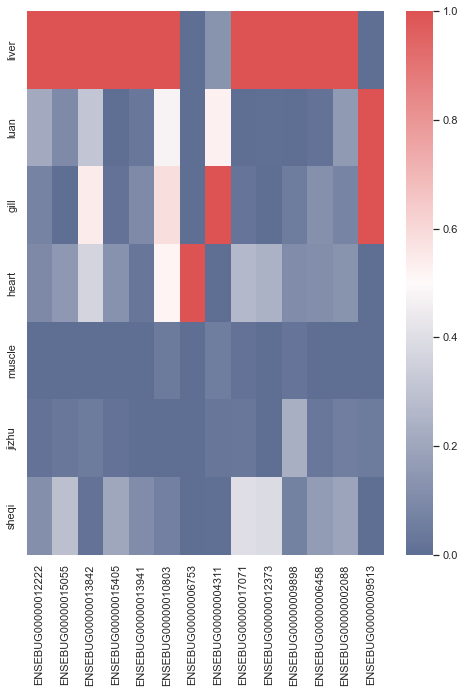

In [57]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
hagfish2=np.log2(hagfish+1)
sort_index = ['liver', 'luan', 'gill','heart','muscle', 'jizhu',  'sheqi']
hagfish2 = hagfish2.reindex(sort_index,axis=1)
hagfish2_norm = (hagfish2.T-hagfish2.T.min())/(hagfish2.T.max()-hagfish2.T.min())
sns.heatmap(pd.DataFrame(hagfish2_norm[['ENSEBUG00000012222','ENSEBUG00000015055','ENSEBUG00000013842','ENSEBUG00000015405', 'ENSEBUG00000013941','ENSEBUG00000010803', 'ENSEBUG00000006753','ENSEBUG00000004311','ENSEBUG00000017071','ENSEBUG00000012373','ENSEBUG00000009898','ENSEBUG00000006458', 'ENSEBUG00000002088','ENSEBUG00000009513']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(lamprey2.T[['QSM067708','QSM067710','QSM169004','QSM112763']]),cmap=cmap,linecolor='white')




# lamprey2=np.log2(lamprey+1)
# lamprey3=lamprey2[lamprey2.index.isin(lamprey_DEG['gene'])]
# lamprey3['names']=lamprey3.index.map(gene_name['lamprey'])
# lamprey3.set_index('names',inplace=True)
# lamprey3.index=make_index_unique(lamprey3.index)
# lamprey3.sort_index(inplace=True)
# lamprey3_norm = (lamprey3.T-lamprey3.T.min())/(lamprey3.T.max()-lamprey3.T.min())
# sort_index = ['liver', 'intestine', 'kidney', 'gill', 'muscle', 'testis',  'brain', 'oralGland', 'ovary', 'bone',
#        'heart',  'supraneuralBody', 'eye']
# lamprey3_norm = lamprey3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=1)
# sns.heatmap(lamprey3_norm[['QSM067708','QSM067710','QSM169004','QSM112763']],cmap=cmap,linecolor='white')
plt.savefig('01.凝血gene/hagfish_F-genes.pdf',dpi=300)

meta NOT subset; don't know how to subset; dropped


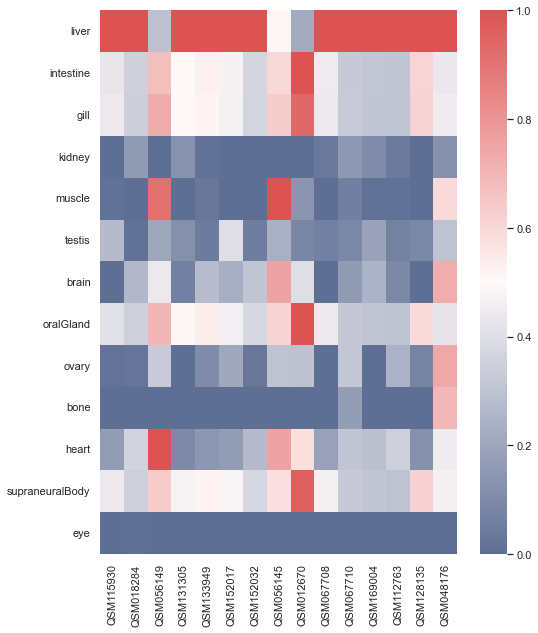

In [40]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
lamprey2=np.log2(lamprey+1)
sort_index = ['liver', 'intestine', 'gill','kidney','muscle', 'testis',  'brain', 'oralGland', 'ovary', 'bone',
       'heart',  'supraneuralBody', 'eye']
lamprey2 = lamprey2.reindex(sort_index,axis=1)
lamprey2_norm = (lamprey2.T-lamprey2.T.min())/(lamprey2.T.max()-lamprey2.T.min())
sns.heatmap(pd.DataFrame(lamprey2_norm[['QSM115930','QSM018284','QSM056149','QSM131305', 'QSM133949', 'QSM152017', 'QSM152032','QSM056145','QSM012670','QSM067708','QSM067710','QSM169004','QSM112763','QSM128135','QSM048176']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(lamprey2.T[['QSM067708','QSM067710','QSM169004','QSM112763']]),cmap=cmap,linecolor='white')




# lamprey2=np.log2(lamprey+1)
# lamprey3=lamprey2[lamprey2.index.isin(lamprey_DEG['gene'])]
# lamprey3['names']=lamprey3.index.map(gene_name['lamprey'])
# lamprey3.set_index('names',inplace=True)
# lamprey3.index=make_index_unique(lamprey3.index)
# lamprey3.sort_index(inplace=True)
# lamprey3_norm = (lamprey3.T-lamprey3.T.min())/(lamprey3.T.max()-lamprey3.T.min())
# sort_index = ['liver', 'intestine', 'kidney', 'gill', 'muscle', 'testis',  'brain', 'oralGland', 'ovary', 'bone',
#        'heart',  'supraneuralBody', 'eye']
# lamprey3_norm = lamprey3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=1)
# sns.heatmap(lamprey3_norm[['QSM067708','QSM067710','QSM169004','QSM112763']],cmap=cmap,linecolor='white')
plt.savefig('01.凝血gene/lamprey_F-genes.pdf',dpi=300)

In [ ]:
# sns.clustermap(lamprey3_norm,cmap=cmap,method='ward',metric='euclidean',col_cluster=False)

<AxesSubplot:>

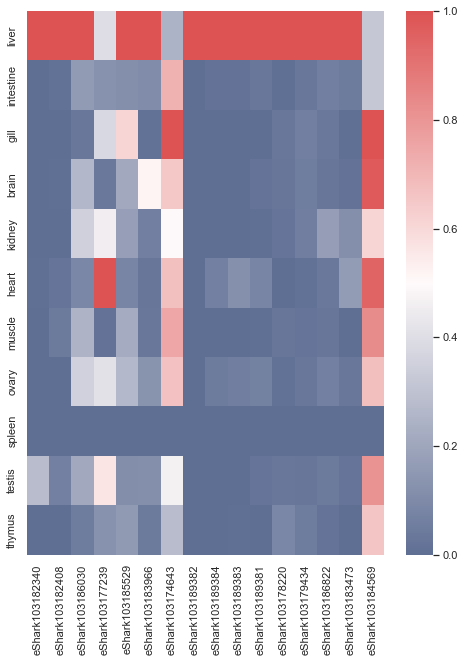

In [58]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
elephantshark2=np.log2(elephantshark+1)
sort_index = ['liver','intestine','gill','brain', 'kidney', 'heart', 'muscle',
       'ovary', 'spleen', 'testis', 'thymus']
elephantshark2 = elephantshark2.reindex(sort_index,axis=1)
elephantshark2_norm = (elephantshark2.T-elephantshark2.T.min())/(elephantshark2.T.max()-elephantshark2.T.min())
sns.heatmap(pd.DataFrame(elephantshark2_norm[['eShark103182340', 'eShark103182408','eShark103186030','eShark103177239','eShark103185529','eShark103183966','eShark103174643','eShark103189382', 'eShark103189384','eShark103189383','eShark103189381','eShark103178220','eShark103179434','eShark103186822','eShark103183473','eShark103184569']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(dogshark2.T[['PRE00685','PRE00684','PRE00686']]),cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/elephantshark_F-genes.pdf',dpi=300)

In [6]:
elephantshark.columns

Index(['brain', 'gill', 'heart', 'intestine', 'kidney', 'liver', 'muscle',
       'ovary', 'spleen', 'testis', 'thymus'],
      dtype='object')

<AxesSubplot:>

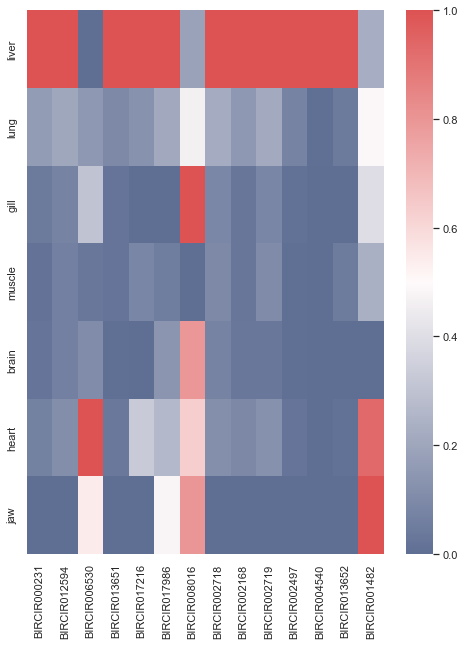

In [61]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
bichir2=np.log2(bichir+1)
sort_index = ['liver','lung','gill','muscle', 'brain', 'heart','jaw']
bichir2 = bichir2.reindex(sort_index,axis=1)
bichir2_norm = (bichir2.T-bichir2.T.min())/(bichir2.T.max()-bichir2.T.min())
sns.heatmap(pd.DataFrame(bichir2_norm[['BIRCIR000231','BIRCIR012594','BIRCIR006530','BIRCIR013651','BIRCIR017216','BIRCIR017986','BIRCIR008016', 'BIRCIR002718','BIRCIR002168','BIRCIR002719','BIRCIR002497','BIRCIR004540','BIRCIR013652','BIRCIR001482']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(bichir2.T[['BIRCIR002718','BIRCIR002168','BIRCIR002719']]),cmap=cmap,linecolor='white')



# bichir2=np.log2(bichir+1)
# bichir3=bichir2[bichir2.index.isin(bichir_DEG['gene'].to_list() + ['FGB'])]
# bichir3['names']=bichir3.index.map(gene_name['bichir'])
# bichir3.set_index('names',inplace=True)
# bichir3.index=make_index_unique(bichir3.index)
# bichir3.sort_index(inplace=True)
# bichir3_norm = (bichir3.T-bichir3.T.min())/(bichir3.T.max()-bichir3.T.min())
# sort_index = ['liver','muscle', 'brain', 'heart', 'gill', 'lung', 'jaw']
# bichir3_norm = bichir3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=1)
# sns.heatmap(bichir3_norm,cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/bichir_F-genes.pdf',dpi=300)

<AxesSubplot:>

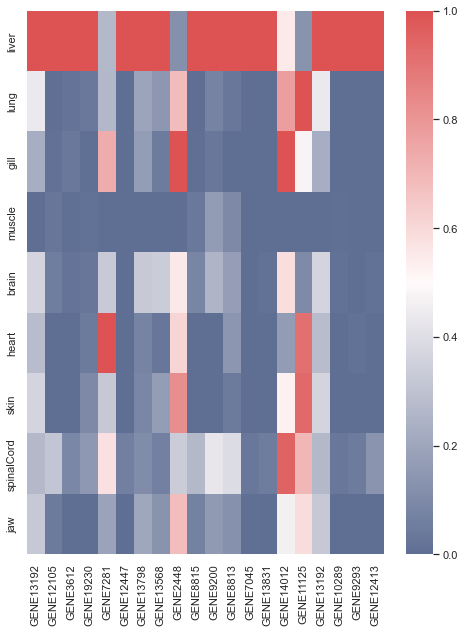

In [64]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
lungfish2=np.log2(lungfish+1)
sort_index = ['liver','lung','gill','muscle', 'brain', 'heart', 'skin','spinalCord', 'jaw']
lungfish2 = lungfish2.reindex(sort_index,axis=1)
lungfish2_norm = (lungfish2.T-lungfish2.T.min())/(lungfish2.T.max()-lungfish2.T.min())
sns.heatmap(pd.DataFrame(lungfish2_norm[['GENE13192','GENE12105','GENE3612','GENE19230','GENE7281','GENE12447', "GENE13798",'GENE13568','GENE2448','GENE8815','GENE9200','GENE8813','GENE7045','GENE13831','GENE14012','GENE11125','GENE13192','GENE10289','GENE9293','GENE12413']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(lungfish2.T[['GENE10289','GENE12413']]),cmap=cmap,linecolor='white')


# lungfish3=lungfish2[lungfish2.index.isin(lungfish_DEG['gene'].to_list())]
# lungfish3['names']=lungfish3.index.map(gene_name['lungfish'])
# lungfish3.set_index('names',inplace=True)
# lungfish3.index=make_index_unique(lungfish3.index)
# lungfish3.sort_index(inplace=True)
# lungfish3_norm = (lungfish3.T-lungfish3.T.min())/(lungfish3.T.max()-lungfish3.T.min())
# sort_index = ['liver','lung','muscle', 'brain', 'heart', 'gill', 'skin','spinalCord', 'jaw']
# lungfish3_norm = lungfish3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=0.8)
# sns.heatmap(lungfish3_norm,cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/lungfish_F-genes.pdf',dpi=300)

In [15]:
hagfish.loc[['ENSEBUG00000012373','ENSEBUG00000017071','ENSEBUG00000011984','ENSEBUG00000007521','ENSEBUG00000011984']]
hagfish1=hagfish.loc[['ENSEBUG00000011984']]

In [118]:
hagfish1.index=['hagfish']
hagfish1.rename(columns={'luan':'testis','jizhu':'bone'},inplace=True)

In [119]:
order1 =['liver','muscle', 'heart',  'gill', 'testis','sheqi', 'bone']
hagfish1 = hagfish1.reindex(order1,axis=1)

In [120]:
hagfish1

,liver,muscle,heart,gill,testis,sheqi,bone
hagfish,253.032349,30.270605,102.918088,118.016627,21.917143,2.718673,16.500107


In [121]:
lamprey.loc[['QSM112763','QSM169004','QSM067708', 'QSM067710','QSM077943','QSM077976','HMOX1','QSM077943','QSM077976']]
lamprey1=lamprey.loc[['HMOX1']]

In [122]:
lamprey1.index=['lamprey']
lamprey1

,supraneuralBody,heart,intestine,eye,liver,gill,muscle,bone,oralGland,testis,kidney,brain,gonad
lamprey,0.0,0.0,0.0,0.778592,60.325977,0.0,0.780192,0.0,0.0,5.833439,0.855312,3.018831,3.077884


In [123]:
order2=['liver','intestine', 'heart', 'eye', 'gill','muscle', 'bone', 'supraneuralBody', 'oralGland', 'testis', 'kidney', 'brain', 'gonad']
lamprey1 = lamprey1.reindex(order2,axis=1)

In [124]:
lamprey1.columns

Index(['liver', 'intestine', 'heart', 'eye', 'gill', 'muscle', 'bone',
       'supraneuralBody', 'oralGland', 'testis', 'kidney', 'brain', 'gonad'],
      dtype='object')

In [54]:
elephantshark.loc[['eShark103189381','eShark103189383','eShark103189382', 'eShark103189384','eShark103189669','eShark103178752']]
elephantshark1=elephantshark.loc[['eShark103189669']]

In [62]:
elephantshark1.index=['elephantshark']
elephantshark1

,brain,gill,heart,intestine,kidney,liver,muscle,ovary,spleen,testis,thymus
elephantshark,4.84835,13.77717,2.556832,2.432331,13.902652,115.262009,1.526541,11.054721,0.0,3.50005,1.677132


In [125]:
order3=['liver','spleen','intestine','brain', 'gill', 'heart',  'kidney', 'muscle','ovary', 'testis', 'thymus']
elephantshark1 = elephantshark1.reindex(order3,axis=1)

In [126]:
elephantshark1

,liver,spleen,intestine,brain,gill,heart,kidney,muscle,ovary,testis,thymus
elephantshark,115.262009,0.0,2.432331,4.84835,13.77717,2.556832,13.902652,1.526541,11.054721,3.50005,1.677132


In [9]:
dogshark.loc[['DogShark027658','DogShark003247']].T

,DogShark027658,DogShark003247
chang,34.766052,44.056451
bone,2.693807,50.990906
skin,5.232525,48.443330
pi,5.285700,41.901772
bbrain,4.900352,191.345846
xingxian,4.838270,54.794527
xiongqijigu,6.525062,49.794868
ya,10.009358,72.024986
neier,2.074209,12.455426
xiongqijibu,3.936149,45.822948


In [63]:
yaoyu.loc[['zhtsy026153','zhtsy018785']]
yaoyu1=yaoyu.loc[['zhtsy026153']]

In [ ]:
yaoyu1.index=['yaoyu']
yaoyu1

In [128]:
order4=['liver','spleen','muscle','heart', 'JiZhuiGu', 'ShangE', 'kidney', 'eye', 'BeiShenJing', 'skin', 'FuQiJiGu', 'Gill', 'ShuLuanGuan','LuanChao', 'YiXian']
yaoyu1 = yaoyu1.reindex(order4,axis=1)

In [ ]:
bichir.loc[['BIRCIR002719','BIRCIR002168','BIRCIR002718','BIRCIR001928','BIRCIR022140']]

In [67]:
zebrafish.loc[['ENSDARG00000027529','ENSDARG00000078452','ENSDARG00000114695']]
zebrafish1=zebrafish.loc[['ENSDARG00000027529']]

In [70]:
zebrafish1.index=['zebrafish']
zebrafish1

,marrow,ovary,intestine,eye,headKidney,liver,gill,muscle,spleen,testis,kidney,brain
zebrafish,56.845422,0.462308,2.172792,3.692667,94.486969,58.237718,14.73507,2.630573,217.798079,40.574623,44.86776,8.766929


In [130]:
order5=['liver','spleen', 'intestine', 'marrow','ovary', 'eye', 'headKidney', 'gill','muscle', 'testis', 'kidney', 'brain']
zebrafish1 = zebrafish1.reindex(order5,axis=1)

In [72]:
stickleback.loc[['ENSGACG00000006771','ENSGACG00000011292']]
stickleback1=stickleback.loc[['ENSGACG00000006771']]
stickleback1.index=['stickleback']
stickleback1.drop(columns=['headKidney'],inplace=True)
stickleback1

,liver,eye,gill,intestinal,skin,muscle,spleen,pectoralFin,testis,kidney,brain
stickleback,2.61076,4.327721,7.679353,1.778913,3.328771,2.119045,604.059314,2.552789,12.256808,22.897293,0.0


In [133]:
order6=['liver', 'spleen', 'eye', 'intestinal', 'gill','headKidney',  'skin', 'muscle',  'pectoralFin', 'testis', 'kidney', 'brain']
stickleback1 = stickleback1.reindex(order6,axis=1)

In [75]:
lungfish.loc[['GENE8813', 'GENE9200','GENE8815','GENE12649','GENE4740']]
lungfish1=lungfish.loc[['GENE12649']]
lungfish1.index=['lungfish']
lungfish1

,heart,liver,gill,jaw,skin,muscle,spleen,lung,brain,spinal
lungfish,18.262152,9.408721,31.97396,20.097238,40.3044,0.975717,328.191071,25.419779,28.934697,50.008528


In [135]:
order7=['liver','spleen','gill', 'lung', 'heart', 'jaw', 'skin', 'muscle', 'brain', 'spinal']
lungfish1 = lungfish1.reindex(order7,axis=1)

In [ ]:
frog.drop(columns=['dannang'],inplace=True)
frog.loc[['FROG016347','FROG006494','FROG043267','FROG018193','FROG020904','F0145','FROG046057']]
frog1=frog.loc[['F0145']]
frog1.index=['frog']
frog1

In [137]:
order8=['liver', 'spleen', 'lung', 'kidney', 'heart', 'ovary', 'eye', 'bone', 'muscle', 'brain']
frog1 = frog1.reindex(order8,axis=1)

In [80]:
xenopus1=pd.DataFrame([[39.62,33.48,15.3,62.63,71.55,96.2,48.96,7.15,38.89,4.89,26.02,276.79,51.1,6.7]],columns=['brain','eye','heart','intestine','kidney','liver','lung','muscle','ovary','pancreas','skin','spleen','stomach','testis'],index=['xenopus'])

In [139]:
order9=['liver','spleen','intestine','stomach','lung', 'brain', 'eye', 'heart',  'kidney',  'muscle', 'ovary', 'pancreas', 'skin',   'testis']
xenopus1 = xenopus1.reindex(order9,axis=1)

In [81]:
xenopus1

,brain,eye,heart,intestine,kidney,liver,lung,muscle,ovary,pancreas,skin,spleen,stomach,testis
xenopus,39.62,33.48,15.3,62.63,71.55,96.2,48.96,7.15,38.89,4.89,26.02,276.79,51.1,6.7


In [144]:
Greenlizard.loc[['lizard100552332','lizard100552725','lizard100552530','lizard100555210']]
Greenlizard1=Greenlizard.loc[['lizard100555210']]
Greenlizard1.index=['Greenlizard']
Greenlizard1.drop(columns=['adrenal'],inplace=True)
Greenlizard1

,brain,eye,heart,kidney,liver,lung,ovary,skin,testis
Greenlizard,4.157863,10.256614,8.462872,44.881683,107.682266,61.959339,7.769407,8.432959,48.036949


In [145]:
order10=['liver','lung','kidney','adrenal', 'brain', 'eye', 'heart','ovary','skin','testis']
Greenlizard1 = Greenlizard1.reindex(order10,axis=1)

In [83]:
lengpigui.loc[['lengpigui119860004','lengpigui119862692']]
lengpigui1=lengpigui.loc[['lengpigui119860004']]
lengpigui1.index=['lengpigui']
lengpigui1

,heart,ovary,thymus,spleen,lung,blood,kidney,brain,gonad
lengpigui,4.499007,4.917425,24.674461,151.996964,11.264467,2.261914,17.366542,5.209692,3.49704


In [146]:
order11=['spleen','heart', 'ovary', 'thymus','lung', 'blood', 'kidney','brain', 'gonad']
lengpigui1 = lengpigui1.reindex(order11,axis=1)

In [85]:
chicken.columns=[x.lower() for x in chicken.columns]
chicken.loc[['FGG','FGB','FGA','HMOX1','HMOX2','BLVRA','SLCO1B1','SLCO1B3','ABCC2']]
chicken1=chicken.loc[['HMOX1']]
chicken1.index=['chicken']
chicken1

,muscle,heart,isthmus,skin,liver,eye,adipose,ovary,brain,spleen,pancreas,colon,jejunum,lung,kidney,thyroid,cochlea,thymus
chicken,43.17,18.193333,55.6,51.385,372.656,69.87,51.885,143.44,48.473333,1203.893333,2.42,57.933333,117.33,58.516,139.37,45.8225,58.88,55.486667


In [153]:
order12=['liver','spleen','jejunum','colon','lung', 'muscle', 'heart', 'isthmus', 'skin',  'eye', 'adipose',
       'ovary', 'brain',  'pancreas', 
       'kidney', 'thyroid', 'cochlea', 'thymus']
chicken1 = chicken1.reindex(order12,axis=1)

In [154]:
mouse.loc[['FGG','FGB','FGA','HMOX1','HMOX2','BLVRA','SLCO1B2','ABCC2']]
mouse1=mouse.loc[['HMOX1']]
mouse1.index=['mouse']
mouse1['spleen']=329.98
mouse1

,adipose,bladder,brain,cerebellum,foregut,heart,kindey,liver,lung,muscle,olfactory,ovary,pancreas,placenta,retina,skin,stomach,testis,thymus,spleen
mouse,10.9846,15.0131,1.22926,1.84083,14.1285,6.94869,12.6914,12.0388,94.4853,6.91212,0.0,26.17,7.75918,86.8982,0.655805,69.9626,16.9849,5.14524,7.77397,329.98


In [155]:
order13=['liver','spleen','foregut', 'stomach','lung', 'kindey','adipose', 'bladder', 'brain', 'cerebellum', 'heart',
        'muscle', 'olfactory', 'ovary', 'pancreas',
       'placenta', 'retina', 'skin',  'testis', 'thymus']
mouse1 = mouse1.reindex(order12,axis=1)

In [156]:
human.loc[['FGG','FGB','FGA','HMOX1','HMOX2','BLVRA','SLCO1B1','SLCO1B3','ABCC2']].T
human1=human.loc[['HMOX1']]
human1.index=['human']
human1.rename(columns={'retina':'eye','cerebellum':'brain','skeletal_muscle':'muscle','small_intestine':'intestine','heart_muscle':'heart'},inplace=True)

In [157]:
order14=['liver', 'spleen','lung','intestine','colon','stomach','pancreas','heart', 'kidney','muscle','eye','skin','ovary','brain', 'adipose_tissue', 'adrenal_gland', 'amygdala', 'appendix',
       'basal_ganglia', 'bone_marrow', 'breast', 'cerebral_cortex','cervix', 'choroid_plexus',  'duodenum', 'endometrium',
       'epididymis', 'esophagus', 'fallopian_tube', 'gallbladder', 
       'hippocampal_formation', 'hypothalamus', 
       'lymph_node', 'medulla_oblongata', 'midbrain',  
       'parathyroid_gland', 'pituitary_gland', 'placenta', 'pons', 'prostate',
       'rectum', 'salivary_gland', 'seminal_vesicle',  
        'smooth_muscle', 'spinal_cord', 
       'testis', 'thalamus', 'thymus', 'thyroid_gland', 'tongue', 'tonsil',
       'urinary_bladder', 'vagina', 'white_matter']
human1=human1.reindex(order14,axis=1)

In [ ]:
human.loc[['FGG','FGB','FGA','HMOX1','HMOX2','BLVRA','BLVRB','SLCO1B1','SLCO1B3','ABCC2','CYP1A2']].T

In [ ]:
chicken.loc[['CYP1A2']].T

In [158]:
df=pd.concat([hagfish1,lamprey1,elephantshark1,yaoyu1,zebrafish1,stickleback1,lungfish1,frog1,xenopus1,Greenlizard1,lengpigui1,chicken1,mouse1,human1],axis=0)

In [159]:
df

,liver,muscle,heart,gill,testis,sheqi,bone,intestine,eye,supraneuralBody,...,seminal_vesicle,smooth_muscle,spinal_cord,thalamus,thyroid_gland,tongue,tonsil,urinary_bladder,vagina,white_matter
hagfish,253.032349,30.270605,102.918088,118.016627,21.917143,2.718673,16.500107,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lamprey,60.325977,0.780192,0.000000,0.000000,5.833439,NaN,0.000000,0.000000,0.778592,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elephantshark,115.262009,1.526541,2.556832,13.777170,3.500050,NaN,NaN,2.432331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yaoyu,278.662506,21.989908,3.894240,NaN,NaN,NaN,NaN,NaN,15.230623,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zebrafish,58.237718,2.630573,NaN,14.735070,40.574623,NaN,NaN,2.172792,3.692667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stickleback,2.610760,2.119045,NaN,7.679353,12.256808,NaN,NaN,NaN,4.327721,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lungfish,9.408721,0.975717,18.262152,31.973960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frog,106.578280,8.052220,4.996383,NaN,NaN,NaN,7.898452,NaN,0.871890,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xenopus,96.200000,7.150000,15.300000,NaN,6.700000,NaN,NaN,62.630000,33.480000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Greenlizard,107.682266,NaN,8.462872,NaN,48.036949,NaN,NaN,NaN,10.256614,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


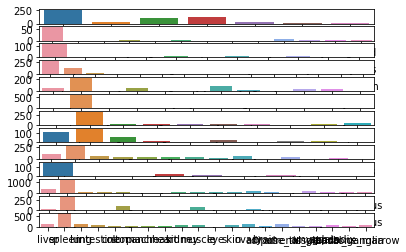

In [170]:
fig, axes = plt.subplots(13,1)
sns.barplot(data=hagfish1,ax=axes[0])
sns.barplot(data=lamprey1,ax=axes[1])
sns.barplot(data=elephantshark1,ax=axes[2])
sns.barplot(data=yaoyu1,ax=axes[3])
sns.barplot(data=zebrafish1,ax=axes[4])
sns.barplot(data=stickleback1,ax=axes[5])
sns.barplot(data=lungfish1,ax=axes[6])
sns.barplot(data=frog1,ax=axes[7])
sns.barplot(data=xenopus1,ax=axes[8])
# sns.barplot(data=Greenlizard1,ax=axes[9])
sns.barplot(data=lengpigui1,ax=axes[9])
sns.barplot(data=chicken1,ax=axes[10])
sns.barplot(data=mouse1,ax=axes[11])
sns.barplot(data=human1.T.head(20).T,ax=axes[12])
plt.savefig('HMOX1.pdf',dpi=300)

In [ ]:
####### 胆绿素分解过程相关基因  #############


In [177]:
lamprey.loc[['QSM155116','QSM165210']]

,supraneuralBody,heart,intestine,eye,liver,gill,muscle,bone,oralGland,testis,kidney,brain,gonad
QSM155116,58.219738,30.545494,64.087097,0.0,0.0,57.193764,28.078504,0.0,62.005531,0.0,31.759163,15.814585,0.0
QSM165210,52.054192,28.493980,62.645573,0.0,0.0,59.575863,26.993507,0.0,77.005600,0.0,25.843549,15.213962,0.0


In [178]:
elephantshark.loc[['eShark103176853']]

,brain,gill,heart,intestine,kidney,liver,muscle,ovary,spleen,testis,thymus
eShark103176853,10.839878,15.167375,2.278263,136.371109,121.179527,83.836197,10.479237,69.6642,0.0,16.246241,3.889709


In [179]:
yaoyu.loc[['zhtsy019995','zhtsy019996','zhtsy019997']]

,heart,JiZhuiGu,ShangE,kidney,eye,BeiShenJing,liver,skin,FuQiJiGu,muscle,spleen,Gill,ShuLuanGuan,LuanChao,YiXian
zhtsy019995,6.649631,0.809190,7.030416,117.417694,5.112114,1.136965,111.937500,5.097991,0.469650,0.826550,0.734641,15.775970,1.356523,6.012203,0.124814
zhtsy019996,12.391096,13.861432,26.146088,79.086105,28.715168,15.040377,114.850311,19.040449,17.060366,2.347502,8.822389,27.661409,7.112868,12.504000,0.440508
zhtsy019997,0.000000,0.000000,0.000000,3.148480,0.000000,0.000000,11.556060,0.364664,0.260843,0.000000,0.000000,0.770892,0.000000,0.000000,0.000000


In [176]:
lungfish.loc[['GENE16007','GENE14811','GENE15645']]

,heart,liver,gill,jaw,skin,muscle,spleen,lung,brain,spinal
GENE16007,0.401371,10.087957,12.467585,5.993423,8.033216,0.104509,7.772239,2.181255,0.120242,0.340540
GENE14811,0.047090,7.628213,0.543883,1.344683,0.525100,0.070418,2.333447,1.496515,0.075483,0.335628
GENE15645,0.259659,189.456686,0.189343,0.309319,0.173864,0.161718,0.203328,0.269161,2.014698,2.908358


In [ ]:
human.loc[['UGT1A1']].T

<AxesSubplot:>

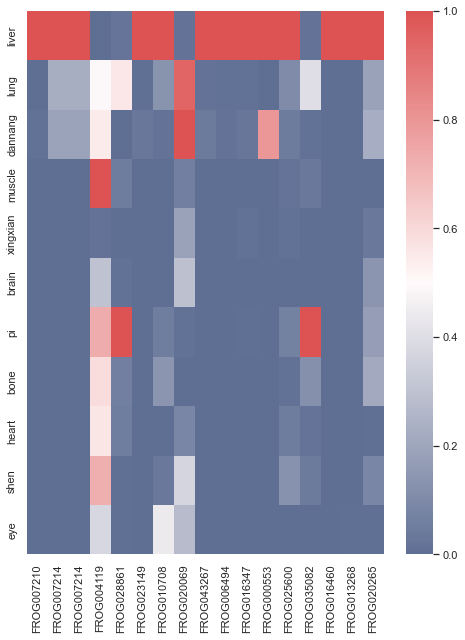

In [66]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
frog2=np.log2(frog+1)
sort_index = ['liver','lung','dannang', 'muscle', 'xingxian', 'brain', 'pi', 'bone', 'heart', 'shen',  'eye']
frog2 = frog2.reindex(sort_index,axis=1)
frog2_norm = (frog2.T-frog2.T.min())/(frog2.T.max()-frog2.T.min())
sns.heatmap(pd.DataFrame(frog2_norm[['FROG007210', 'FROG007214','FROG007214','FROG004119', 'FROG028861', 'FROG023149','FROG010708','FROG020069','FROG043267','FROG006494','FROG016347','FROG000553','FROG025600','FROG035082','FROG016460','FROG013268','FROG020265']]),cmap=cmap,linecolor='white')
#sns.heatmap(pd.DataFrame(frog2.T[['FROG013268','FROG020265']]),cmap=cmap,linecolor='white')   ###########"FROG007214"用作F2

# frog2=np.log2(frog+1)
# frog3=frog2[frog2.index.isin(frog_DEG['gene'].to_list())]
# frog3['names']=frog3.index.map(gene_name['frog'])
# frog3.set_index('names',inplace=True)
# frog3.index=make_index_unique(frog3.index)
# frog3.sort_index(inplace=True)
# frog3_norm = (frog3.T-frog3.T.min())/(frog3.T.max()-frog3.T.min())
# sort_index = ['liver','lung','dannang', 'muscle', 'xingxian', 'brain', 'pi', 'bone', 'heart', 'shen',  'eye']
# frog3_norm = frog3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=0.8)
# sns.heatmap(frog3_norm,cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/frog_F-genes.pdf',dpi=300)

<AxesSubplot:xlabel='Gene ID'>

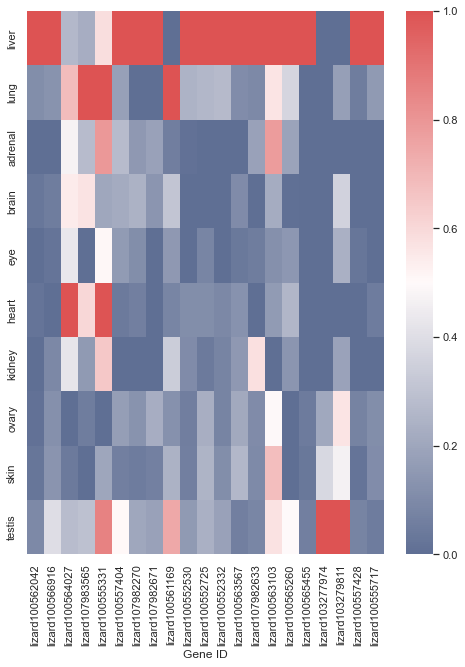

In [67]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
Greenlizard2=np.log2(Greenlizard+1)
sort_index = ['liver', 'lung','adrenal', 'brain', 'eye', 'heart', 'kidney',  'ovary','skin', 'testis']
Greenlizard2 = Greenlizard2.reindex(sort_index,axis=1)
Greenlizard2_norm = (Greenlizard2.T-Greenlizard2.T.min())/(Greenlizard2.T.max()-Greenlizard2.T.min())
#sns.heatmap(pd.DataFrame(lizard2.T[['LIZARD01352','LIZARD03022']]),cmap=cmap,linecolor='white')
sns.heatmap(pd.DataFrame(Greenlizard2_norm[['lizard100562042','lizard100566916','lizard100564027','lizard107983565','lizard100555331','lizard100557404','lizard107982270', 'lizard107982671','lizard100561169','lizard100552530','lizard100552725','lizard100552332','lizard100563567','lizard107982633','lizard100563103','lizard100565260', 'lizard100565455', 'lizard103277974', 'lizard103279811','lizard100557428','lizard100555717']]),cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/lizard_F-genes.pdf',dpi=300)

<AxesSubplot:>

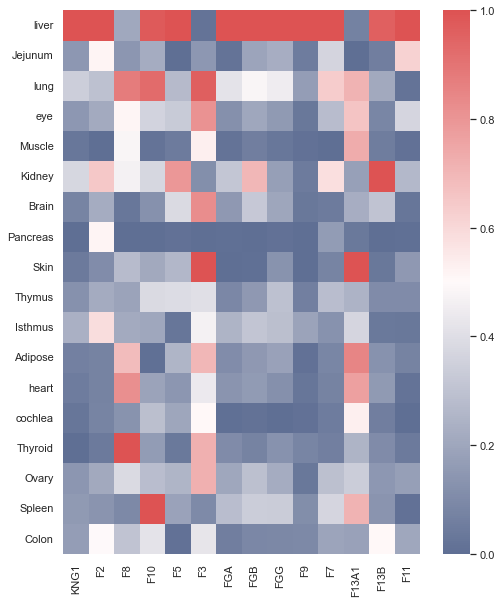

In [68]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
chicken2=np.log2(chicken+1)
sort_index = ['liver','Jejunum','lung', 'eye', 'Muscle', 'Kidney', 'Brain',   'Pancreas',
       'Skin', 'Thymus', 'Isthmus', 'Adipose',  'heart','cochlea',
       'Thyroid', 'Ovary', 'Spleen', 'Colon']
chicken2 = chicken2.reindex(sort_index,axis=1)
chicken2_norm = (chicken2.T-chicken2.T.min())/(chicken2.T.max()-chicken2.T.min())
#sns.heatmap(pd.DataFrame(chicken2.T[['F11']]),cmap=cmap,linecolor='white')
sns.heatmap(pd.DataFrame(chicken2_norm[['KNG1','F2','F8','F10','F5','F3','FGA','FGB','FGG','F9','F7','F13A1','F13B','F11']]),cmap=cmap,linecolor='white')
# plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/commonTran_Figures/chicken_F11-F12.pdf',dpi=300)
# plt.savefig('01.凝血gene/chicken_F-genes.pdf',dpi=300)

meta NOT subset; don't know how to subset; dropped


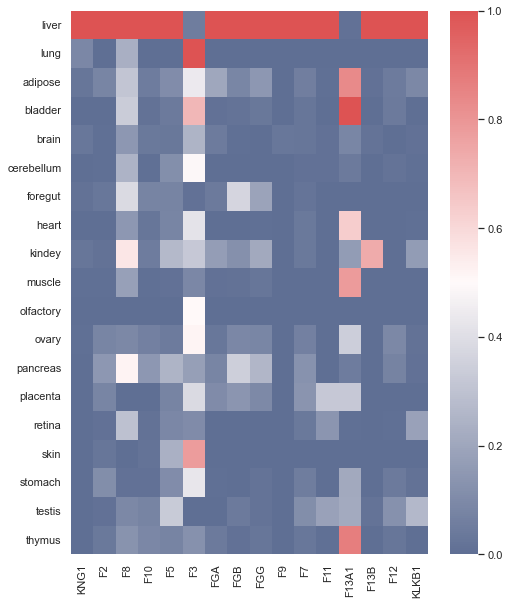

In [69]:
sns.set(rc = {'figure.figsize':(8,10)})
sns.set(style='white', font_scale=1)
mouse2=np.log2(mouse+1)
sort_index = ['liver','lung','adipose', 'bladder', 'brain', 'cerebellum', 'foregut', 'heart',
       'kindey', 'muscle', 'olfactory', 'ovary', 'pancreas',
       'placenta', 'retina', 'skin', 'stomach', 'testis', 'thymus']
mouse2 = mouse2.reindex(sort_index,axis=1)
mouse2_norm = (mouse2.T-mouse2.T.min())/(mouse2.T.max()-mouse2.T.min())
#sns.heatmap(pd.DataFrame(mouse2.T[['KLKB1','F11','F12']]),cmap=cmap,linecolor='white')
sns.heatmap(pd.DataFrame(mouse2_norm[['KNG1','F2','F8','F10','F5','F3','FGA','FGB','FGG','F9','F7','F11','F13A1','F13B','F12','KLKB1']]),cmap=cmap,linecolor='white')

# mouse2=np.log2(mouse+1)
# mouse3=mouse2[mouse2.index.isin(mouse_DEG['gene'].to_list())]
# mouse3['names']=mouse3.index.map(gene_name['mouse'])
# mouse3.set_index('names',inplace=True)
# mouse3.index=make_index_unique(mouse3.index)
# mouse3.sort_index(inplace=True)
# mouse3_norm = (mouse3.T-mouse3.T.min())/(mouse3.T.max()-mouse3.T.min())
# sort_index = ['liver','lung','adipose', 'bladder', 'brain', 'cerebellum', 'foregut', 'heart',
#        'kindey', 'muscle', 'olfactory', 'ovary', 'pancreas',
#        'placenta', 'retina', 'skin', 'stomach', 'testis', 'thymus']
# mouse3_norm = mouse3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=0.8)
# sns.heatmap(mouse3_norm,cmap=cmap,linecolor='white')
# plt.savefig('mouse_DEG.pdf',dpi=300)
plt.savefig('01.凝血gene/mouse_F-genes.pdf',dpi=300)

<AxesSubplot:>

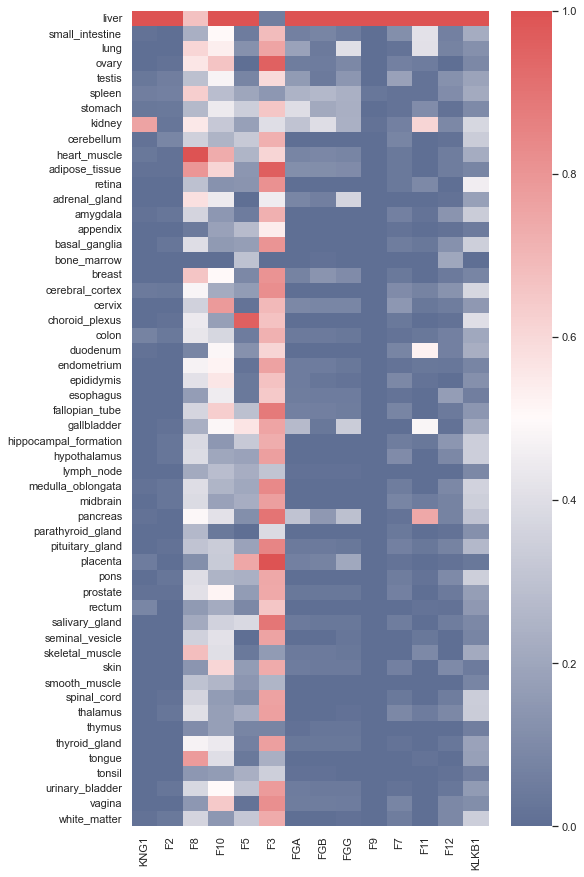

In [104]:
sns.set(rc = {'figure.figsize':(8,15)})
sns.set(style='white', font_scale=1)
human2=np.log2(human+1)
sort_index = ['liver', 'small_intestine','lung','ovary','testis','spleen', 'stomach','kidney', 'cerebellum','heart_muscle','adipose_tissue','retina',
       'adrenal_gland', 'amygdala', 'appendix',
       'basal_ganglia', 'bone_marrow', 'breast', 'cerebral_cortex', 'cervix', 'choroid_plexus', 'colon', 'duodenum',
       'endometrium', 'epididymis', 'esophagus', 'fallopian_tube',
       'gallbladder',  'hippocampal_formation', 'hypothalamus',
       'lymph_node', 'medulla_oblongata','midbrain', 'pancreas', 'parathyroid_gland', 'pituitary_gland',
       'placenta', 'pons', 'prostate', 'rectum', 'salivary_gland',
       'seminal_vesicle', 'skeletal_muscle', 'skin', 
       'smooth_muscle', 'spinal_cord',  'thalamus', 'thymus', 'thyroid_gland', 'tongue', 'tonsil',
       'urinary_bladder', 'vagina', 'white_matter']
human2 = human2.reindex(sort_index,axis=1)
human2_norm = (human2.T-human2.T.min())/(human2.T.max()-human2.T.min())
#sns.heatmap(pd.DataFrame(human2.T[['KLKB1','F11','F12']]),cmap=cmap,linecolor='white')
sns.heatmap(pd.DataFrame(human2_norm[['KNG1','F2','F8','F10','F5','F3','FGA','FGB','FGG','F9','F7','F11','F12','KLKB1']]),cmap=cmap,linecolor='white')
# plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/commonTran_Figures/human_F11-F12.pdf',dpi=300)


# human2=np.log2(human+1)
# human3=human2[human2.index.isin(human_DEG['gene'].to_list())]
# human3['names']=human3.index.map(gene_name['human'])
# human3.set_index('names',inplace=True)
# human3.index=make_index_unique(human3.index)
# human3.sort_index(inplace=True)
# human3_norm = (human3.T-human3.T.min())/(human3.T.max()-human3.T.min())
# sort_index = ['liver', 'small_intestine','lung','adipose_tissue', 'adrenal_gland', 'amygdala', 'appendix',
#        'basal_ganglia', 'bone_marrow', 'breast', 'cerebellum',
#        'cerebral_cortex', 'cervix', 'choroid_plexus', 'colon', 'duodenum',
#        'endometrium', 'epididymis', 'esophagus', 'fallopian_tube',
#        'gallbladder', 'heart_muscle', 'hippocampal_formation', 'hypothalamus',
#        'kidney',  'lymph_node', 'medulla_oblongata',
#        'midbrain', 'ovary', 'pancreas', 'parathyroid_gland', 'pituitary_gland',
#        'placenta', 'pons', 'prostate', 'rectum', 'retina', 'salivary_gland',
#        'seminal_vesicle', 'skeletal_muscle', 'skin', 
#        'smooth_muscle', 'spinal_cord', 'spleen', 'stomach', 'testis',
#        'thalamus', 'thymus', 'thyroid_gland', 'tongue', 'tonsil',
#        'urinary_bladder', 'vagina', 'white_matter']
# human3_norm = human3_norm.reindex(sort_index,axis=0)
# sns.set(rc = {'figure.figsize':(20,10)})
# sns.set(style='white', font_scale=0.8)
# sns.heatmap(human3_norm,cmap=cmap,linecolor='white')
# plt.savefig('01.凝血gene/human_F-genes.pdf',dpi=300)

In [ ]:
mouse_path = os.listdir('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/mouse')
df_mouse=pd.DataFrame()
for i in mouse_path:
    if i.endswith('.txt'):
        tissues = i.split('.')[0]
        df_t = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/mouse/'+i,sep='\t',header=0)
        df_t['Gene_Symbol']=df_t['Gene_Symbol'].str.upper()
        df_t = df_t[['Gene_Symbol','RPKM']]
        df_t.set_index('Gene_Symbol',inplace=True)
        df_t.index=make_index_unique(df_t.index)
        df_t.columns=[tissues]
        print(df_t)
        df_mouse = pd.concat([df_mouse,pd.DataFrame(df_t)],join='outer',axis=1)


In [59]:
####### lungfish Trans
df_lungfish=pd.read_csv('lungfish_TPM.txt',sep='\t',header=0,index_col=0)
df_lungfish=np.log2(df_lungfish+1)

In [61]:
df_lungfish.index=make_index_unique(df_lungfish.index)

In [55]:
[x for x in df_lungfish.index if x.startswith('FGG')]

['FGG', 'FGGY']

In [62]:
marker_lungfish=['FGA','FGB','FGG']

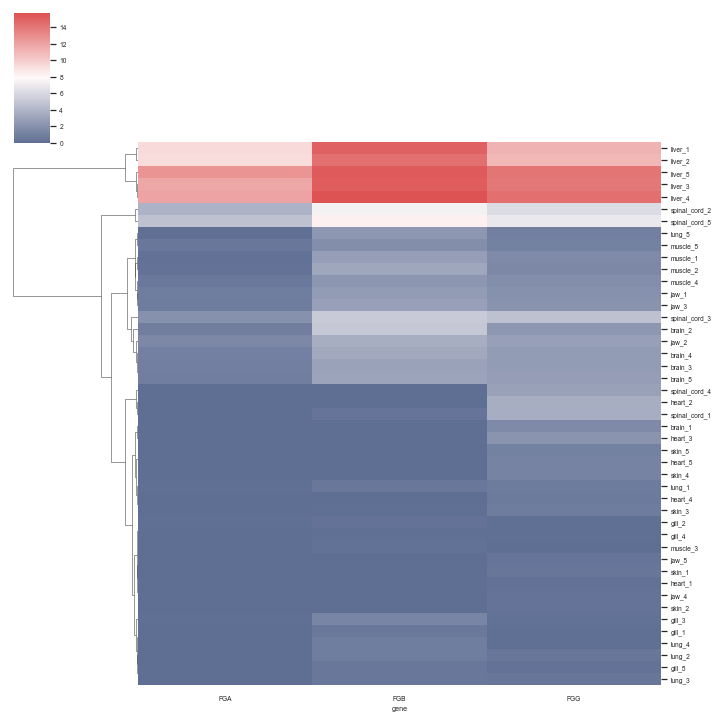

In [70]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.set(style='white', font_scale=0.6)
sns.clustermap(df_lungfish.T[marker_lungfish],cmap=cmap,method='ward',metric='euclidean',col_cluster=False)

In [180]:
df=pd.read_csv('D:/046.google download/rna_tissue_consensus.tsv',sep='\t',header=0,index_col=None)

In [181]:
df1=df.pivot(index='Gene',columns='Tissue',values='nTPM')

In [182]:
dict1=dict(zip(df['Gene'],df['name']))

In [183]:
df1['gene_name']=df1.index.map(dict1)

In [184]:
df1.columns.name=None

In [185]:
tmp =df1['gene_name']

In [186]:
df1.drop('gene_name',axis=1,inplace=True)
df1.insert(0,'gene_name',tmp)

In [187]:
df1.set_index('gene_name',inplace=True)

In [188]:
df1.index.name=None

In [189]:
df1.index=make_index_unique(df1.index)

In [191]:
df1.columns=[re.sub(r'\s','_',x) for x in df1.columns]

In [9]:
import plotly.express as px
import plotly.io as pio
df = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/high_expression_for_liver_enrichment.csv')
df=df[df['source'].str.contains('GO|KEGG')]
df.sort_values(by=['negative_log10_of_adjusted_p_value'],ascending=False,inplace=True)
# df=df.head(50)
df.sort_values(by=['negative_log10_of_adjusted_p_value'],ascending=False,inplace=True)
fig = px.scatter(df,x=df['negative_log10_of_adjusted_p_value'], y=df['intersection_size'],size="intersection_size",height=600,width=800,color=df['source'])  ##,text=df2['term_name']
fig.update_traces(marker=dict(sizemode='area',
                              sizeref=2.*max(df['intersection_size'])/(50.**2),
                              sizemin=4,
                              line_width=1))

fig.update_layout(uniformtext_minsize=2, uniformtext_mode='hide')
fig.add_annotation(x=21.344673, y=16, text="Complement and coagulation cascades", showarrow=True, font_size=20)
fig.add_annotation(x=12.113790,y=13,text="Blood coagulation",showarrow=True, font_size=20)
fig.add_annotation(x=14.382794,y=12,text="Blood microparticle",showarrow=True, font_size=20)
fig.show()
# pio.write_image(fig,'./liver_tou-expression_enrichment.pdf', format='pdf')

In [26]:
gene_name = {}
gene_name = gene2Name()
keys = []
for x in gene_name.keys():
    for y in gene_name[x].keys():
        if gene_name[x][y] == 'BLVRA':
            keys.append(y)
print(keys)

['BIRCIR021010', 'BLVRA', 'PRE03374', 'eShark103181265', 'FROG032866', 'lizard100564394', 'ENSEBUG00000014460', 'BLVRA', 'QSM062182', 'GENE18754', 'BLVRA']


In [170]:
human.T[['CYP7A1','CYP7B1','CYP27A1']]

,CYP7A1,CYP7B1,CYP27A1
adipose_tissue,0.2,8.4,23.1
adrenal_gland,0.0,5.4,50.3
amygdala,0.0,5.7,45.2
appendix,0.0,5.6,15.7
basal_ganglia,0.0,11.4,59.0
bone_marrow,0.0,0.3,1.3
breast,0.1,6.3,21.8
cerebellum,0.1,8.2,57.0
cerebral_cortex,0.6,6.6,59.3
cervix,0.0,5.7,27.6


In [169]:
mouse.T[['CYP7A1','CYP7B1','CYP27A1']]

,CYP7A1,CYP7B1,CYP27A1
adipose,0.000000,1.035590,17.277000
bladder,0.000000,4.784120,17.774500
brain,0.247137,0.519782,0.325694
cerebellum,0.000000,2.002610,5.407280
foregut,0.000000,0.401516,0.562292
heart,0.000000,0.292583,8.827680
kindey,0.000000,1.283980,13.640500
liver,19.643200,306.009000,375.630000
lung,0.000000,31.249500,1.024380
muscle,0.000000,0.169617,51.554300


In [168]:
chicken.T[['CYP7A1','CYP7B1','CYP27A1']]

,CYP7A1,CYP7B1,CYP27A1
heart,0.070000,15.393333,12.973333
Thymus,0.406667,11.425000,2.403333
Muscle,0.030000,3.033333,11.400000
Adipose,0.020000,6.560000,3.620000
Thyroid,0.502500,12.192500,105.665000
Spleen,0.130000,14.290000,2.693333
cochlea,0.093333,111.310000,26.883333
Kidney,0.190000,42.396667,36.806667
lung,0.370000,41.060000,20.154000
Colon,0.156667,8.736667,17.983333


In [171]:
Greenlizard.T[['lizard100562614','lizard100564185','lizard100565025']]

Gene ID,lizard100562614,lizard100564185,lizard100565025
adrenal,0.000000,4.745465,4.499228
brain,0.070448,26.119064,38.583298
eye,0.352514,2.358655,2.988745
heart,0.182164,0.772717,24.112490
kidney,0.000000,11.968916,63.168667
liver,26.394131,51.430222,79.555878
lung,0.114460,10.254104,15.265383
ovary,0.974016,0.356802,5.833877
skin,1.105168,1.360664,6.772979
testis,0.621694,26.848228,14.912591


In [ ]:
frog.T[['FROG003797','FROG021577','FROG006784']]

In [ ]:
bichir.T[['BIRCIR015000','BIRCIR001077','BIRCIR019339']]

In [ ]:
zebrafish.T[['ENSDARG00000069018','ENSDARG00000008858','ENSDARG00000088013']]

In [ ]:
lungfish.T[['GENE11015','GENE15860','GENE10926','GENE18548']]

In [ ]:
elephantshark.T[['eShark103180710','eShark103180767','eShark103189020']]

In [ ]:
###'zhtsy029081'-cyp27a1
yaoyu.T[['zhtsy004754','zhtsy020793','zhtsy029081']]

In [ ]:
dogshark.T[['DogShark010448','DogShark001112','DogShark011753']]

In [ ]:
lamprey.T[[ 'QSM104912','QSM049292']]

In [ ]:
###ENSEBUG00000002885-cyp27a1
hagfish.T[['ENSEBUG00000000542','ENSEBUG00000002885']]

In [ ]:
lancelet.T[['BL05380','BL16751']]

In [16]:
#### 定义一个函数，按照列进行标准化
def standardizeROW(df):
    df_norm = (df.T-df.T.min())/(df.T.max()-df.T.min())
    return df_norm

In [17]:
lancelet3 = lancelet.T[['BL05380','BL16751']]
lancelet3['CYP7A1']=lancelet3.sum(axis=1)
lancelet3= lancelet3[['CYP7A1']]
lancelet4 = (lancelet3-lancelet3.min())/(lancelet3.max()-lancelet3.min())
# lancelet3.rename({})

In [18]:
lancelet4.rename({'digestive tract':'intestine','cerebellum':"brain",'hepatic cecum':'liver','muscle tissue':'muscle','skin epidermis':'skin','egg cell':'egg'},inplace=True)

In [19]:
lancelet4

Gene ID,CYP7A1
muscle,0.064112
gastrula,0.024055
testis,0.035506
skin,0.170849
ovary,0.003808
intestine,0.300126
oral cirrus,0.052075
pharyngeal slit,0.397277
blastula,0.000982
liver,1.000000


In [20]:
hagfish4=standardizeROW(hagfish)[['ENSEBUG00000000542','ENSEBUG00000002885']]
hagfish4.rename({'ENSEBUG00000000542':'CYP7A1','ENSEBUG00000002885':"CYP27A1"},axis=1,inplace=True)

In [21]:
hagfish4.rename({'digestive tract':'intestine','cerebellum':"brain",'hepatic cecum':'liver','muscle tissue':'muscle','skin epidermis':'skin','luan':'egg','sheqi':'tongue','jizhu':'spinal'},inplace=True)

In [22]:
hagfish4

,CYP7A1,CYP27A1
gill,0.011876,0.000424
liver,1.000000,1.000000
egg,0.000000,0.020770
spinal,0.000000,0.014498
heart,0.000000,0.008137
muscle,0.001093,0.000000
tongue,0.006129,0.001407


In [23]:
lamprey4=standardizeROW(lamprey)[['QSM104912','QSM049292']]
lamprey4.rename({'QSM104912':'CYP7A1','QSM049292':"CYP27A1"},axis=1,inplace=True)

In [24]:
lamprey4.rename({'gonad':'ovary'},inplace=True)
lamprey4

,CYP7A1,CYP27A1
gill,0.792345,0.975573
liver,0.000000,0.000000
testis,0.000000,0.002342
supraneuralBody,0.986855,0.892754
eye,0.000000,0.000000
oralGland,1.000000,0.956901
ovary,0.000000,0.040690
heart,0.428162,0.469084
bone,0.000000,0.109980
muscle,0.440485,0.516611


In [25]:
elephantshark4=standardizeROW(elephantshark)[['eShark103180710','eShark103180767','eShark103189020']]
elephantshark4.rename({'eShark103180710':'CYP7A1','eShark103180767':'CYP7B1','eShark103189020':"CYP27A1"},axis=1,inplace=True)

In [26]:
elephantshark4

,CYP7A1,CYP7B1,CYP27A1
brain,0.222583,0.163843,0.010772
gill,0.082407,0.054457,0.051481
heart,0.019944,0.103801,0.010677
intestine,0.054005,0.324996,0.045315
kidney,0.129558,0.074797,0.005223
liver,1.000000,1.000000,1.000000
muscle,0.030620,0.107369,0.009084
ovary,0.032799,0.188835,0.000000
spleen,0.000000,0.000000,0.000000
testis,0.009683,0.072553,0.010360


In [27]:
dogshark4=standardizeROW(dogshark)[['DogShark010448','DogShark001112','DogShark011753']]
dogshark4.rename({'DogShark010448':'CYP7A1','DogShark001112':'CYP7B1','DogShark011753':"CYP27A1"},axis=1,inplace=True)

In [28]:
dogshark4.rename({'xingxian':'ovary','jingchao':'testis','yi':"pancreas",'chang':'intestine','bbrain':'brain'},inplace=True)
dogshark4.drop(['pi'],axis=0,inplace=True)
dogshark4

,CYP7A1,CYP7B1,CYP27A1
hufu,0.004022,0.198984,0.089329
spleen,0.000000,0.188655,0.000000
brain,0.399759,0.066937,0.001283
heart,0.084368,0.237906,0.000000
bone,0.037842,0.098636,0.000000
kidney,1.000000,0.109783,0.003495
sail,0.000000,0.003233,0.026369
gill,0.000000,0.092342,1.000000
liver,0.793323,0.027030,0.000000
eye,0.245820,0.160689,0.000000


In [29]:
bichir4=standardizeROW(bichir)[['BIRCIR015000','BIRCIR001077','BIRCIR019339']]
bichir4.rename({'BIRCIR015000':'CYP7A1','BIRCIR001077':'CYP7B1','BIRCIR019339':"CYP27A1"},axis=1,inplace=True)

In [30]:
bichir4

,CYP7A1,CYP7B1,CYP27A1
liver,1.000000,0.633344,0.219003
gill,0.000000,0.798025,1.000000
lung,0.000000,0.748864,0.109611
jaw,0.000225,0.974963,0.531838
heart,0.000000,1.000000,0.239488
muscle,0.000415,0.000000,0.000000
brain,0.000000,0.843474,0.193547


In [31]:
zebrafish4=standardizeROW(zebrafish)[['ENSDARG00000069018','ENSDARG00000008858','ENSDARG00000088013']]
zebrafish4.rename({'ENSDARG00000069018':'CYP7A1','ENSDARG00000008858':'CYP7B1','ENSDARG00000088013':"CYP27A1"},axis=1,inplace=True)

In [32]:
zebrafish.T[['ENSDARG00000069018','ENSDARG00000008858','ENSDARG00000088013']]

,ENSDARG00000069018,ENSDARG00000008858,ENSDARG00000088013
gill,1.026362,26.438784,3.365022
liver,0.735645,6.156377,12.459980
testis,0.000000,1.697022,3.941625
spleen,89.209793,0.888702,6.422537
ovary,0.949415,3.048549,0.218781
marrow,220.280941,3.931481,1.482539
eye,0.309420,2.921990,0.691281
headKidney,50.760471,1.020477,6.211782
muscle,4.702712,0.589576,2.031830
brain,0.249424,5.185196,25.610039


In [33]:
lungfish4=standardizeROW(lungfish)[['GENE11015','GENE10926','GENE18548']]
lungfish4.rename({'GENE11015':'CYP7A1','GENE10926':'CYP7B1','GENE18548':"CYP27A1"},axis=1,inplace=True)

In [34]:
lungfish4

,CYP7A1,CYP7B1,CYP27A1
gill,1.000000,1.000000,0.220225
liver,0.005864,0.371096,0.361063
lung,0.022408,0.000000,0.025612
spleen,0.825024,0.819384,1.000000
jaw,0.032319,0.199766,0.135231
spinal,0.009484,0.000000,0.244927
heart,0.002612,0.000000,0.159576
skin,0.051822,0.173924,0.191126
muscle,0.000000,0.000000,0.000000
brain,0.002113,0.000000,0.196746


In [35]:
frog4=standardizeROW(frog)[['FROG003797','FROG021577','FROG006784']]
frog4.rename({'FROG003797':'CYP7A1','FROG021577':'CYP7B1','FROG006784':"CYP27A1"},axis=1,inplace=True)

In [36]:
frog4

,CYP7A1,CYP7B1,CYP27A1
liver,1.000000,0.077209,0.342009
lung,0.000000,0.129242,0.123773
spleen,0.000000,0.077897,0.067311
ovary,0.000000,0.078718,0.801317
eye,0.000000,0.016872,0.026402
dannang,0.000000,0.000000,0.386495
heart,0.000000,0.050847,0.160679
bone,0.007766,0.067007,0.080422
muscle,0.000000,0.015045,0.000000
brain,0.000000,1.000000,0.191489


In [37]:
Greenlizard4=standardizeROW(Greenlizard)[['lizard100562614','lizard100564185','lizard100565025']]
Greenlizard4.rename({'lizard100562614':'CYP7A1','lizard100564185':'CYP7B1','lizard100565025':"CYP27A1"},axis=1,inplace=True)

In [38]:
Greenlizard4

Gene ID,CYP7A1,CYP7B1,CYP27A1
adrenal,0.000000,0.085929,0.019728
brain,0.002669,0.504416,0.464880
eye,0.013356,0.039196,0.000000
heart,0.006902,0.008143,0.275885
kidney,0.000000,0.227361,0.785976
liver,1.000000,1.000000,1.000000
lung,0.004337,0.193786,0.160338
ovary,0.036903,0.000000,0.037159
skin,0.041872,0.019655,0.049424
testis,0.023554,0.518693,0.155731


In [102]:
chicken4=standardizeROW(chicken)[['CYP7A1','CYP7B1','CYP27A1']]
mouse4=standardizeROW(mouse)[['CYP7A1','CYP7B1','CYP27A1']]
human4=standardizeROW(human)[['CYP7A1','CYP7B1','CYP27A1']]

In [103]:
human_index = ['liver', 'small_intestine','lung','ovary','testis','spleen', 'stomach','kidney', 'cerebellum','heart_muscle','adipose_tissue','retina','skeletal_muscle','skin','tongue','bone_marrow']
human4 = human4.loc[human_index]
human4.rename({'small_intestine':'intestine','cerebellum':"brain",'heart_muscle':'heart','skeletal_muscle':'muscle','retina':'eye','bone_marrow':'marrow','adipose_tissue':'adipose'},inplace=True)

In [104]:
mouse4.rename({'foregut':'intestine','retina':'eye','kindey':'kidney'},inplace=True)

In [105]:
mouse4

,CYP7A1,CYP7B1,CYP27A1
adipose,0.000000,0.003384,0.045995
bladder,0.000000,0.015634,0.047319
brain,0.012581,0.001699,0.000867
cerebellum,0.000000,0.006544,0.014395
intestine,0.000000,0.001312,0.001497
heart,0.000000,0.000956,0.023501
kidney,0.000000,0.004196,0.036314
liver,1.000000,1.000000,1.000000
lung,0.000000,0.102120,0.002727
muscle,0.000000,0.000554,0.137248


In [106]:
chicken4.index=[x.lower() for x in chicken4.index]
chicken4.rename({'jejunum':'intestine'},inplace=True)

In [43]:
chicken4

,CYP7A1,CYP7B1,CYP27A1
thyroid,0.039369,0.084590,0.560655
liver,0.743405,0.889801,1.000000
lung,0.028777,0.351199,0.104541
intestine,0.000000,0.046724,0.024696
ovary,1.000000,0.084521,0.492487
adipose,0.000799,0.032571,0.016349
eye,0.030376,0.494443,0.092731
muscle,0.001599,0.000000,0.057847
cochlea,0.006661,1.000000,0.140435
thymus,0.031708,0.077502,0.009859


In [107]:
pd.concat([human4,mouse4,chicken4,Greenlizard4,frog4,lungfish4,zebrafish4,bichir4,dogshark4,elephantshark4,lamprey4,hagfish4,lancelet4],axis=0)

,CYP7A1,CYP7B1,CYP27A1
liver,1.000000,0.788889,1.000000
intestine,0.000000,0.059259,0.135896
lung,0.000000,0.162963,0.118698
ovary,0.000000,0.148148,0.052774
testis,0.002020,0.055556,0.019052
...,...,...,...
embryo,0.015239,NaN,NaN
primary dorsal nerve cord,0.323008,NaN,NaN
neurula embryo,0.009903,NaN,NaN
larva,0.029155,NaN,NaN


In [108]:
df_cyp7a1 = pd.concat([human4['CYP7A1'],mouse4['CYP7A1'],chicken4['CYP7A1'],Greenlizard4['CYP7A1'],frog4['CYP7A1'],lungfish4['CYP7A1'],bichir4['CYP7A1'],dogshark4['CYP7A1'],elephantshark4['CYP7A1'],lamprey4['CYP7A1'],hagfish4['CYP7A1'],lancelet4['CYP7A1']],axis=1)
df_cyp7a1.columns = ['human','mouse','chicken','Greenlizard','frog','lungfish','bichir','dogshark','elephantshark','lamprey','hagfish','lancelet']

In [109]:
# df_cyp7a1=df_cyp7a1.iloc[::-1]
df_cyp7a1=df_cyp7a1.iloc[:, ::-1]

In [ ]:
import plotly.graph_objs as go
import numpy as np
cmap = sns.blend_palette(['#5F6F94','#FFFAFA','#DD5353'],as_cmap=True)   ##4C6793
# create the heatmap trace
heatmap_trace = go.Heatmap(z=df_cyp7a1,x=df_cyp7a1.columns, y=df_cyp7a1.index,colorscale=['#5F6F94','#FFFAFA','#DD5353'])

# create the layout
layout = go.Layout(title='CYP7A1 expression level',width=1000, height=1000)

# create the figure
fig = go.Figure(data=[heatmap_trace], layout=layout)

# show the fi
fig.show()
fig.write_image("H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/figures/CYP7A1_expression_level.pdf")

meta NOT subset; don't know how to subset; dropped


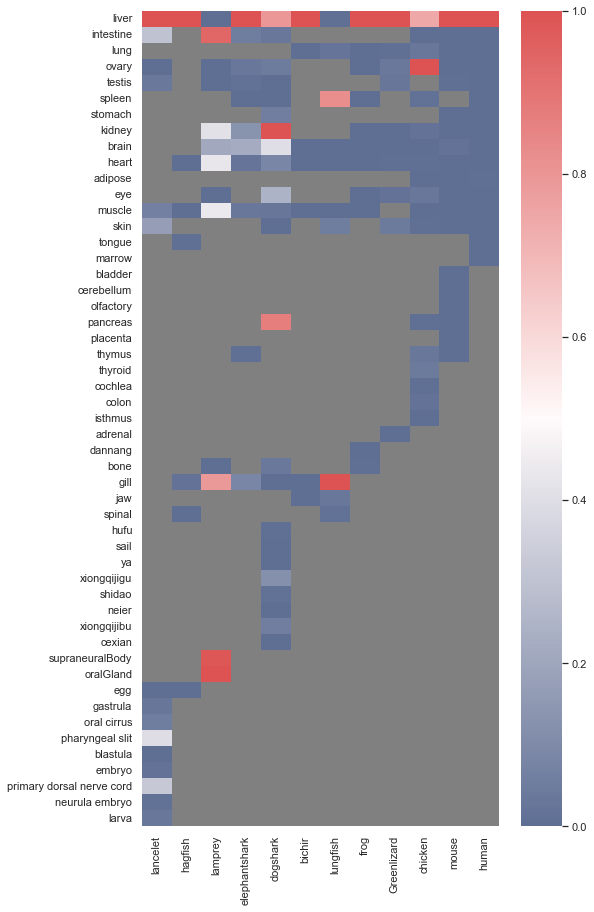

In [110]:
import seaborn as sns
cmap = sns.blend_palette(['#5F6F94','#FFFAFA','#DD5353'],as_cmap=True)   ##4C6793
cmap.set_bad(color='grey')
sns.set(rc = {'figure.figsize':(8,15)})
sns.set(style='white', font_scale=1)
sns.heatmap(df_cyp7a1,cmap=cmap,linecolor='white')
plt.savefig("H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/figures/CYP7A1_expression_level.pdf")

In [111]:
df_cyp7a1.shape

(51, 12)

In [112]:
df_cyp27a1 = pd.concat([human4['CYP27A1'],mouse4['CYP27A1'],chicken4['CYP27A1'],Greenlizard4['CYP27A1'],frog4['CYP27A1'],lungfish4['CYP27A1'],bichir4['CYP27A1'],dogshark4['CYP27A1'],elephantshark4['CYP27A1'],lamprey4['CYP27A1'],hagfish4['CYP27A1'],lancelet4['CYP7A1']],axis=1)
df_cyp27a1.columns = ['human','mouse','chicken','Greenlizard','frog','lungfish','bichir','dogshark','elephantshark','lamprey','hagfish','lancelet']
df_cyp27a1=df_cyp27a1.iloc[:, ::-1]

In [113]:
df_cyp27a1.shape

(51, 12)

meta NOT subset; don't know how to subset; dropped


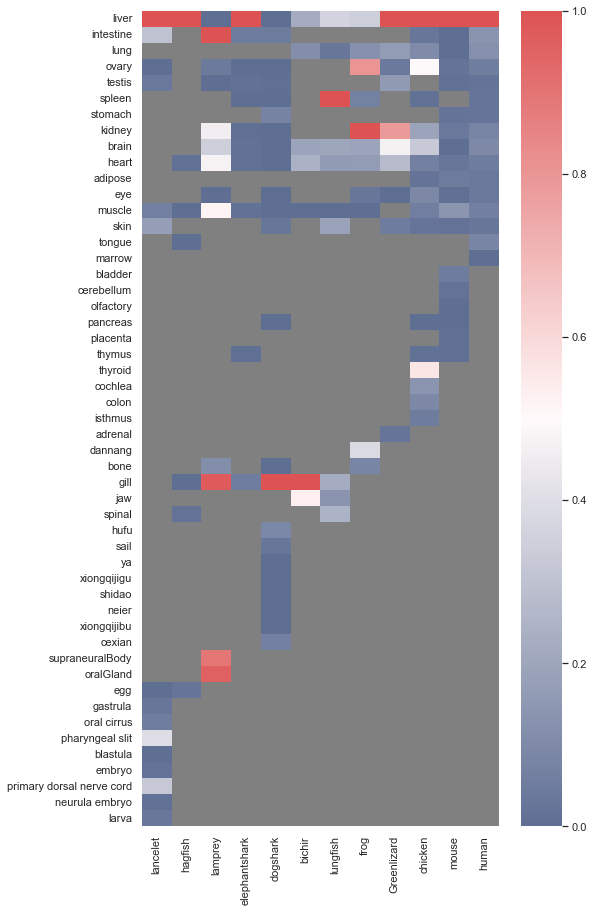

In [114]:
import seaborn as sns
cmap = sns.blend_palette(['#5F6F94','#FFFAFA','#DD5353'],as_cmap=True)   ##4C6793
cmap.set_bad(color='grey')
sns.set(rc = {'figure.figsize':(8,15)})
sns.set(style='white', font_scale=1)
sns.heatmap(df_cyp27a1,cmap=cmap,linecolor='white')
plt.savefig("H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/figures/CYP27A1_expression_level.pdf")

In [115]:
df_cyp7b1 = pd.concat([human4['CYP7B1'],mouse4['CYP7B1'],chicken4['CYP7B1'],Greenlizard4['CYP7B1'],frog4['CYP7B1'],lungfish4['CYP7B1'],bichir4['CYP7B1'],dogshark4['CYP7B1'],elephantshark4['CYP7B1'],lamprey4['CYP27A1'],hagfish4['CYP27A1'],lancelet4['CYP7A1']],axis=1)
df_cyp7b1.columns = ['human','mouse','chicken','Greenlizard','frog','lungfish','bichir','dogshark','elephantshark','lamprey','hagfish','lancelet']
df_cyp7b1=df_cyp7b1.iloc[:, ::-1]

meta NOT subset; don't know how to subset; dropped


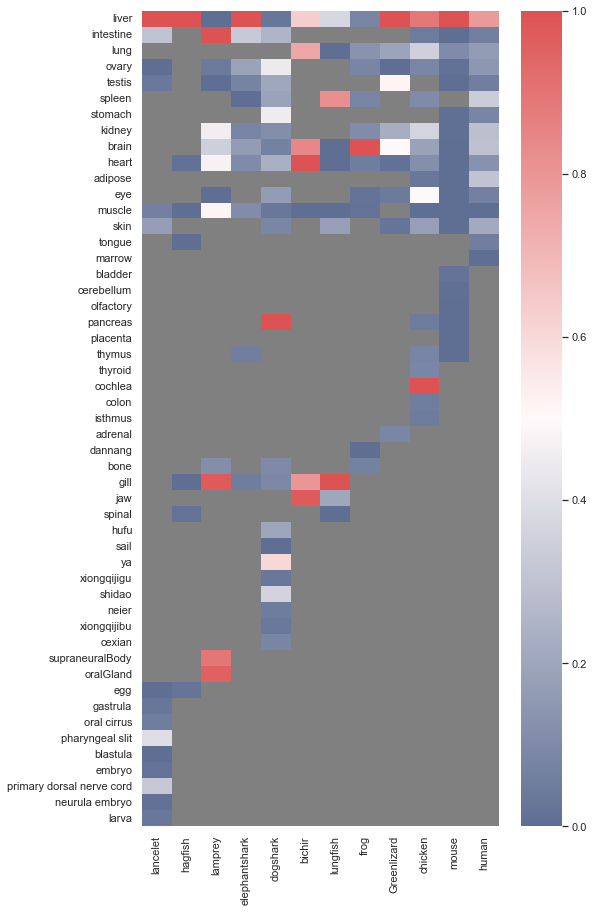

In [116]:
import seaborn as sns
cmap = sns.blend_palette(['#5F6F94','#FFFAFA','#DD5353'],as_cmap=True)   ##4C6793
cmap.set_bad(color='grey')
sns.set(rc = {'figure.figsize':(8,15)})
sns.set(style='white', font_scale=1)
sns.heatmap(df_cyp7b1,cmap=cmap,linecolor='white')
plt.savefig("H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/08.CommonTrans/figures/CYP7B1_expression_level.pdf")

In [ ]:
for i in df_cyp7b1.index:
    print(i)

In [23]:
lancelet.T[['BL95747','BL95746']]

Gene ID,BL95747,BL95746
digestive tract,1.412557,1.566623
neurula embryo,0.112022,0.145211
testis,0.658358,3.445672
embryo,0.131162,0.096207
skin epidermis,55.150091,9.279661
ovary,1.282571,0.544918
primary dorsal nerve cord,0.490818,0.371644
larva,2.007898,0.929182
muscle tissue,2.080932,0.675202
oral cirrus,12.399787,0.983101


In [35]:
gene_name = {}
gene_name = gene2Name()
keys = []
for x in gene_name.keys():
    for y in gene_name[x].keys():
        if gene_name[x][y] == 'BLVRA':
            keys.append(y)
print(keys)

['BIRCIR021010', 'BLVRA', 'PRE03374', 'eShark103181265', 'FROG032866', 'lizard100564394', 'ENSEBUG00000014460', 'BLVRA', 'QSM062182', 'GENE18754', 'BLVRA']


In [ ]:
fiflter_tau_lamprey=filterTau_value(tau_lamprey)
fiflter_tau_lungfish=filterTau_value(tau_lungfish)
fiflter_tau_bichir=filterTau_value(tau_bichir)
fiflter_tau_frog=filterTau_value(tau_frog)
fiflter_tau_human=filterTau_value(tau_human)
fiflter_tau_mouse=filterTau_value(tau_mouse)
fiflter_tau_chicken=filterTau_value(tau_chicken)
fiflter_tau_elephantshark=filterTau_value(tau_elephantshark)
fiflter_tau_Greenlizard=filterTau_value(tau_Greenlizard)
# fiflter_tau_lizard=filterTau_value(tau_lizard)
fiflter_tau_hagfish=filterTau_value(tau_hagfish)

In [62]:
liver_hagfish = filterTau_value(tau_hagfish,key="liver")
liver_lamprey = filterTau_value(tau_lamprey,key="liver")
liver_elephantshrk = filterTau_value(tau_elephantshark,key="liver")
spleen_zebrafish = filterTau_value(tau_zebrafish,key="spleen")
spleen_stickleback = filterTau_value(tau_stickleback,key="spleen")
spleen_lungfish = filterTau_value(tau_lungfish,key="spleen")
spleen_frog = filterTau_value(tau_frog,key="spleen")
spleen_lengpigui = filterTau_value(tau_lengpigui,key="spleen")
spleen_chicken = filterTau_value(tau_chicken,key="Spleen")
# spleen_mouse = filterTau_value(tau_mouse,key="spleen")
spleen_human = filterTau_value(tau_human,key="spleen")

In [71]:
tau_info2 = {'hagfish':liver_hagfish,'lamprey':liver_lamprey,'elephantshark':liver_elephantshrk,'lungfish':spleen_lungfish, 'frog':spleen_frog,'chicken':spleen_chicken,'human':spleen_human}

genes2=[]
for i in tau_info2.keys():
    tau_info2[i]["gene_name"]=tau_info2[i]["gene"].map(gene_name[i])
    genes2=genes2+list(set(tau_info2[i]["gene_name"].to_list()))

In [76]:
import numpy as np
import math
m= set(genes2)
# common_DEG=[]
for x in m:
    if genes2.count(x) >= 5:
        if str(x)=='nan':
            continue
        else:
            a= str(x)
            # common_DEG.append(a)
            print(a)

COL21A1
CARD11
FUT7
SULT2B1


In [14]:
############## the following is to find genes recruit from other tissues

,muscle,brain,eye,oralGland,bone,gonad,testis,liver,kidney,heart,intestine,gill,supraneuralBody
HMOX1,0.780192,3.018831,0.778592,0.000000,0.000000,3.077884,5.833439,60.325977,0.855312,0.000000,0.000000,0.000000,0.000000
QSM000019,31.995207,19.583800,0.000000,60.670918,0.000000,1.159631,0.355381,0.000000,27.934637,31.902497,59.006088,67.821732,61.842529
QSM000026,29.123668,15.775002,0.356089,60.366562,3.274798,18.388292,27.505926,0.000000,32.108554,31.746304,58.520077,57.190792,65.062866
QSM000028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QSM000034,17.790557,16.058722,0.000000,28.234304,0.000000,0.615109,10.549875,0.000000,14.501222,11.649998,25.327465,23.836563,24.812553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
QSM170353,31.775157,16.835718,0.000000,65.707916,0.000000,0.000000,0.000000,0.000000,33.231651,27.367478,68.611229,50.425545,54.623127
QSM170381,37.145771,19.979400,0.039110,63.519608,35.231186,0.737640,3.641556,0.000000,30.090898,75.669113,60.390186,58.052368,60.544510
QSM170382,30.286114,14.575618,0.000000,66.982155,0.000000,0.611402,0.000000,78.424004,28.723562,28.115532,58.743954,66.722672,65.916740
QSM170384,28.645486,15.239553,0.000000,55.350285,0.000000,10.593092,0.379021,0.000000,29.715649,29.452927,59.160423,51.094322,49.801155


In [23]:
homo_lamprey = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/lamprey.homoGenes.txt',sep='\t',header=0,index_col=0)
high_lamprey = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/lamprey_high_variable_genes.txt',sep='\t',header=None,names=["high"],index_col=None)

In [20]:
lamprey_wgd=[]
for i in homo_lamprey['lamprey']:
    line = [x.strip() for x in i.split(',')]
    lamprey_wgd=lamprey_wgd+line

In [32]:
lamprey_ancient=[x for x in high_lamprey['high'] if x not in lamprey_wgd]

In [120]:
lamprey_dir ={}
for colum in lamprey.columns:
    if colum != 'liver':
        tmp = lamprey[lamprey[colum] >=30]
        tmp = tmp[tmp.index.isin(lamprey_ancient)]
        lamprey_dir[colum] = tmp.shape[0]
lamprey_dir



{'muscle': 460,
 'brain': 185,
 'eye': 10,
 'oralGland': 1116,
 'bone': 105,
 'gonad': 178,
 'testis': 190,
 'kidney': 410,
 'heart': 498,
 'intestine': 1107,
 'gill': 1115,
 'supraneuralBody': 1112}

In [342]:
df_lamprey_2 = lamprey[lamprey.index.isin(lamprey_ancient)]
df_lamprey_2[df_lamprey_2<20]=0
# df_lamprey_3 = np.log2(df_lamprey_2+1)

C:\Users\wubaosheng\AppData\Local\Temp\ipykernel_27788\2550822520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lamprey_2[df_lamprey_2<20]=0
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


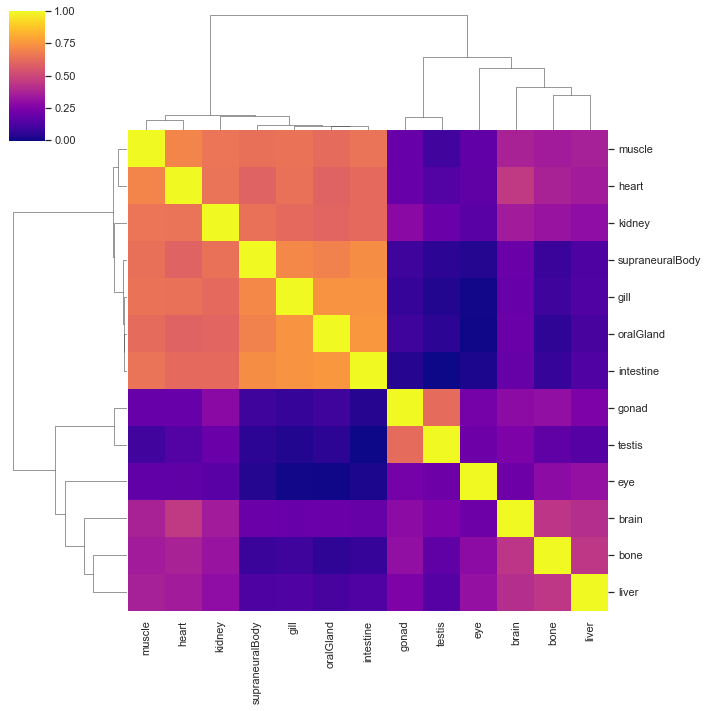

In [343]:
#### seaborn clustermap
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(style='white', font_scale=1)
DF_corr =df_lamprey_2.corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
sns.clustermap(DF_corr,
                figsize=(10,10),
                metric='correlation',  ####euclidean,correlation
                method='average', #####  single, average
                # linewidths=.1,
                cmap='plasma'
            )
#plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/Figures/lampreyrecruitment.svg')


In [297]:
lamprey.columns

Index(['muscle', 'brain', 'eye', 'oralGland', 'bone', 'gonad', 'testis',
       'liver', 'kidney', 'heart', 'intestine', 'gill', 'supraneuralBody'],
      dtype='object')

In [87]:
homo_human = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/human.homoGenes.txt',sep='\t',header=0,index_col=0)
high_human = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/human_high_variable_genes.txt',sep='\t',header=None,names=["high"],index_col=None)

In [88]:
human_wgd=[]
for i in homo_human['human']:
    line = [x.strip() for x in i.split(',')]
    human_wgd=human_wgd+line

In [90]:
human_ancient=[x for x in high_human['high'] if x not in human_wgd]

In [91]:
len(human_ancient)

980

In [313]:
# df_human_2 = human2[human2.index.isin(human_ancient)].iloc[:, :20]


In [337]:
df_human_2 = human[human.index.isin(human_ancient)]
sort_index = ['liver', 'small_intestine','lung','ovary','testis','spleen', 'stomach','kidney', 'cerebellum','heart_muscle','retina', 'skeletal_muscle', 'skin']
df_human_2 = df_human_2[sort_index]

In [339]:
# df_human_2[df_human_2<200]=0

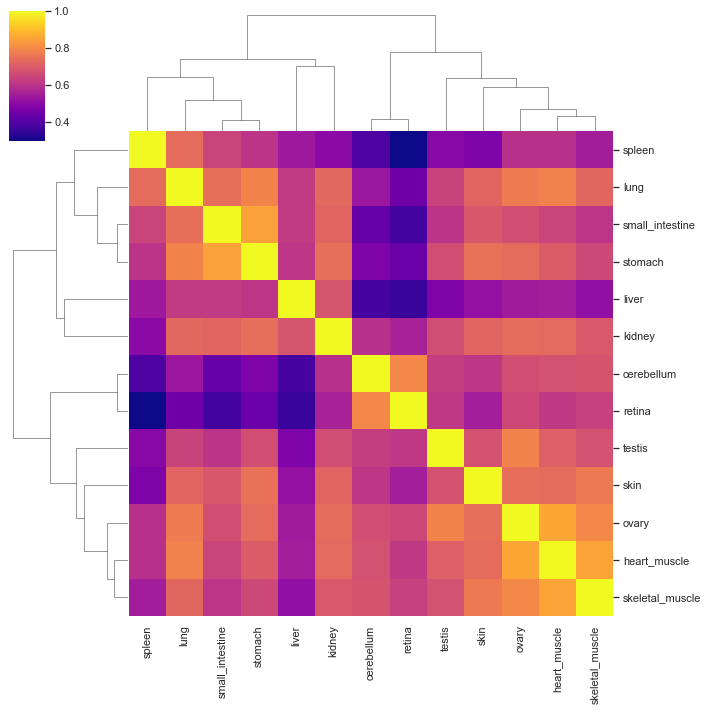

In [341]:
#### seaborn clustermap
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(style='white', font_scale=1)
DF_corr =df_human_2.corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
#DF_corr =df_human_2.corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
sns.clustermap(DF_corr,
                figsize=(10,10),
                metric='correlation',  ####euclidean,correlation
                method='average', #####  single, average
                # linewidths=.1,
                cmap='plasma'
            )
plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/Figures/human_recruitment.svg')


In [307]:
df_human_2.columns

Index(['liver', 'small_intestine', 'lung', 'ovary', 'testis', 'spleen',
       'stomach', 'kidney', 'cerebellum', 'heart_muscle', 'retina', 'colon',
       'skeletal_muscle', 'skin'],
      dtype='object')

In [178]:
homo_dogshark = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/dogshark.homoGenes.txt',sep='\t',header=0,index_col=0)
high_dogshark = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/dogshark_high_variable_genes.txt',sep='\t',header=None,names=["high"],index_col=None)

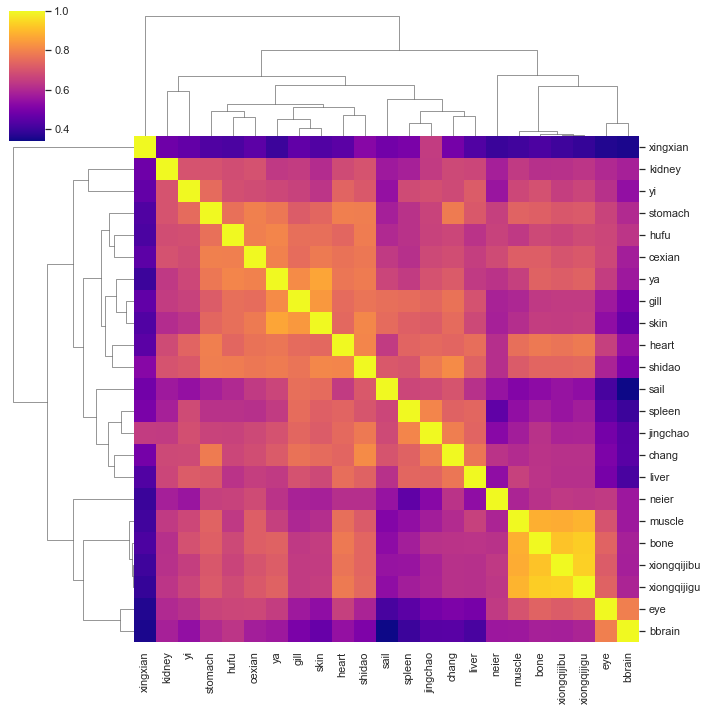

In [305]:
dogshark_wgd=[]
for i in homo_dogshark['dogshark']:
    line = [x.strip() for x in i.split(',')]
    dogshark_wgd=dogshark_wgd+line
dogshark_ancient=[x for x in high_dogshark['high'] if x not in dogshark_wgd]
dogshark_rbh = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/dogshark_RBH.txt',header=None,sep='\t',names=['gene1','gene2'],index_col=None)
rbh = dogshark_rbh.set_index('gene2')['gene1'].to_dict()
dogshark_ancient2 = [rbh[x] for x in dogshark_ancient if x in rbh.keys()]

df_dogshark_2 = dogshark[dogshark.index.isin(dogshark_ancient2)]
df_dogshark_2.drop('pi',axis=1,inplace=True)
# df_dogshark_2[df_dogshark_2<30]=0

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(style='white', font_scale=1)
DF_corr =np.log2(df_dogshark_2+1).corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
sns.clustermap(DF_corr,
                figsize=(10,10),
                metric='correlation',  ####euclidean,correlation
                method='average', #####  single, average
                # linewidths=.1,
                cmap='plasma'
            )
plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/Figures/dogshark_recruitment.svg')

In [301]:
df_dogshark_2.drop('pi',axis=1)

,kidney,gill,muscle,eye,chang,xiongqijibu,hufu,xingxian,yi,heart,...,bone,bbrain,ya,shidao,liver,sail,xiongqijigu,jingchao,skin,cexian
DogShark011465,0.000000,0.000000,0.000000,0.360695,0.000000,0.000000,0.000000,19.799620,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DogShark030177,0.000000,0.000000,0.000000,2.129949,0.000000,0.000000,5.008425,1.462658,0.088984,0.191416,...,0.000000,0.693831,0.001037,2.276547,0.582168,0.000000,0.000000,0.100793,0.086068,0.000000
DogShark030289,0.025703,1.243058,0.064817,0.055536,0.068832,0.021296,0.076603,0.279149,0.000000,0.623951,...,0.086549,0.569236,0.012455,0.032410,0.100424,0.792050,0.142931,0.299764,0.011952,0.000000
DogShark003234,2.391606,54.879311,0.000000,0.910830,4.301452,0.000000,8.780076,31.381403,5.020286,0.913372,...,0.000000,0.526837,1.150113,2.098530,4.930312,0.000000,0.000000,6.714890,8.043948,0.000000
DogShark007351,0.665895,1.743940,0.000000,14.698079,0.141295,0.000000,7.490615,1.776332,0.091741,0.039278,...,0.065327,39.249772,6.088444,1.960385,0.000000,0.000000,0.000000,0.000000,1.201469,2.444756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DogShark018488,2.086374,1.511392,0.407462,7.620933,1.330803,1.763785,5.000440,1.832939,0.840059,5.705078,...,12.999675,2.951664,4.002388,2.156617,1.781726,0.073210,6.164639,2.588702,0.567080,7.180438
DogShark029843,0.182871,0.118806,0.000000,0.387999,0.019194,0.043687,0.155593,0.355878,0.000000,0.000000,...,0.000000,2.584681,0.010888,0.111593,0.006264,0.000000,0.000000,0.087527,0.030601,0.000000
DogShark008527,0.000000,0.000000,0.000000,0.046644,0.000000,0.000000,0.000000,5.383749,0.000000,0.242117,...,0.000000,0.191398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DogShark013927,13.725022,52.190552,7.522838,6.315537,13.787913,8.768693,93.585120,52.940237,0.458905,17.692328,...,24.648273,5.271452,216.395162,141.775823,3.956798,7.037665,12.466193,12.036004,105.719191,81.378552


In [231]:
dogshark_dir ={}
for colum in dogshark.columns:
    if colum != 'liver':
        tmp = dogshark[dogshark[colum] >=10]
        tmp = tmp[tmp.index.isin(dogshark_ancient2)]
        dogshark_dir[colum] = tmp.shape[0]
dogshark_dir

{'kidney': 168,
 'gill': 171,
 'muscle': 113,
 'eye': 160,
 'chang': 159,
 'xiongqijibu': 115,
 'hufu': 224,
 'xingxian': 253,
 'yi': 72,
 'heart': 162,
 'neier': 109,
 'stomach': 131,
 'spleen': 171,
 'pi': 118,
 'bone': 159,
 'bbrain': 205,
 'ya': 193,
 'shidao': 177,
 'sail': 95,
 'xiongqijigu': 146,
 'jingchao': 146,
 'skin': 140,
 'cexian': 130}

C:\Users\wubaosheng\AppData\Local\Temp\ipykernel_27788\2878838548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mouse_2[df_mouse_2<100]=0
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


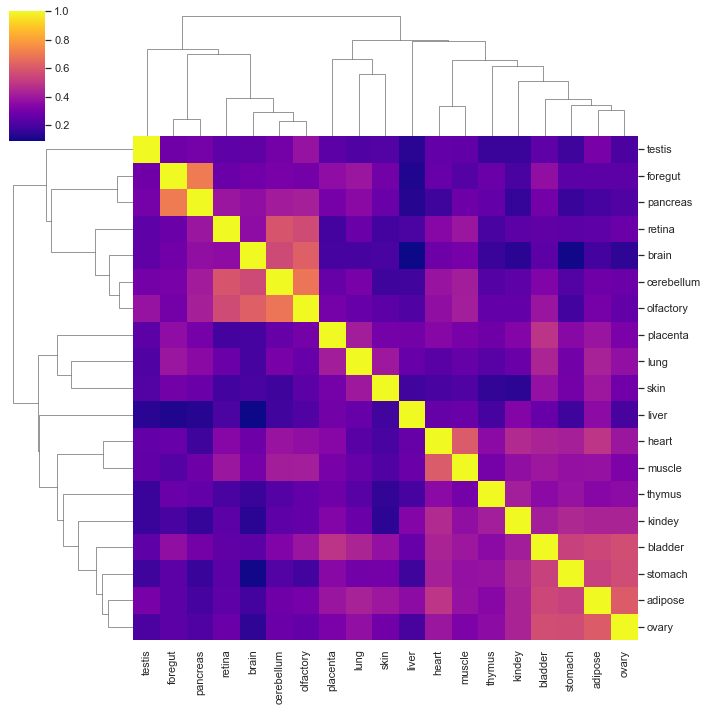

In [260]:
human_wgd=[]
for i in homo_human['human']:
    line = [x.strip() for x in i.split(',')]
    human_wgd=human_wgd+line
human_ancient=[x for x in high_human['high'] if x not in human_wgd]
df_mouse_2 = mouse[mouse.index.isin(human_ancient)]
df_mouse_2[df_mouse_2<100]=0

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(style='white', font_scale=1)
DF_corr =df_mouse_2.corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
# DF_corr =np.log2(df_mouse_2+1).corr(method="pearson")  ###{‘pearson’, ‘kendall’, ‘spearman’}
sns.clustermap(DF_corr,
                figsize=(10,10),
                metric='correlation',  ####euclidean,correlation
                method='average', #####  single, average
                # linewidths=.1,
                cmap='plasma'
            )


C:\Users\wubaosheng\AppData\Local\Temp\ipykernel_27788\1171992325.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frog_2[df_frog_2<40]=0
c:\Users\wubaosheng\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


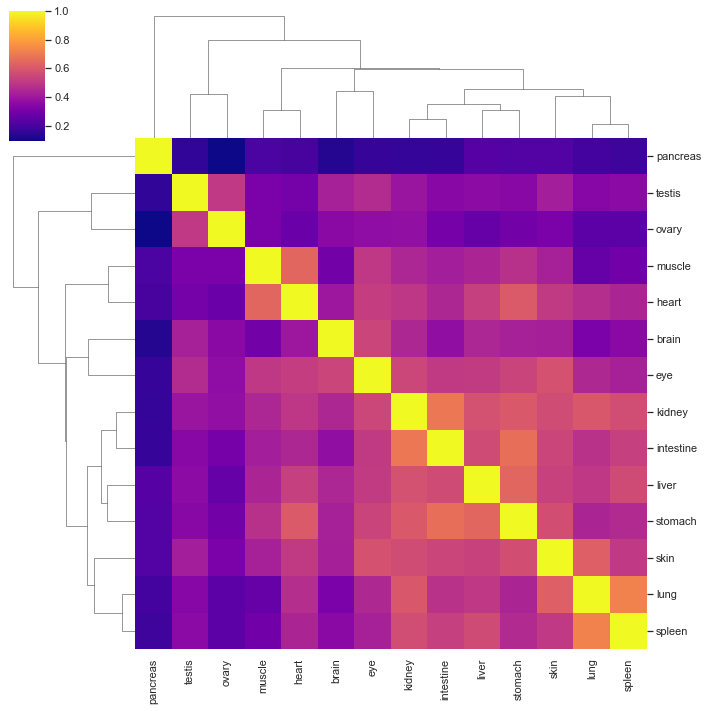

In [296]:
homo_frog = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/frog.homoGenes.txt',sep='\t',header=0,index_col=0)
high_frog = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/frog_high_variable_genes.txt',sep='\t',header=None,names=["high"],index_col=None)
frog_wgd=[]
for i in homo_frog['frog']:
    line = [x.strip() for x in i.split(',')]
    frog_wgd=frog_wgd+line
frog_ancient=[x for x in high_frog['high'] if x not in frog_wgd]
frog_rbh = pd.read_csv('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/frog_RBH.txt',header=None,sep='\t',names=['gene1','gene2'],index_col=None)
frog_rbh['gene2']=frog_rbh['gene2'].str.upper()
rbh = frog_rbh.set_index('gene2')['gene1'].to_dict()
frog_ancient2 = [rbh[x] for x in frog_ancient if x in rbh.keys()]

df_frog_2 = xenopus[xenopus.index.isin(frog_ancient2)]
df_frog_2[df_frog_2<40]=0

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(style='white', font_scale=1)
# DF_corr =np.log2(df_frog_2+1).corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
DF_corr =df_frog_2.corr(method="spearman")  ###{‘pearson’, ‘kendall’, ‘spearman’}
sns.clustermap(DF_corr,
                figsize=(10,10),
                metric='correlation',  ####euclidean,correlation
                method='average', #####  single, average
                # linewidths=.1,
                cmap='plasma'
            )
plt.savefig('H:/002.singcell/01.liver/10.mutileSpecies/05.SAMap/13.homoGenes/Figures/frog_recruitment.svg')

In [306]:
df_frog_2.columns

Index(['muscle', 'brain', 'eye', 'lung', 'testis', 'pancreas', 'liver',
       'kidney', 'heart', 'ovary', 'stomach', 'intestine', 'spleen', 'skin'],
      dtype='object')

In [12]:
fiflter_tau_lancelet=filterTau_value(tau_lancelet,key='hepatic cecum')

In [16]:
fiflter_tau_lancelet=fiflter_tau_lancelet[fiflter_tau_lancelet['rpkm_mean']>1]

In [18]:
for x in fiflter_tau_lancelet['gene']:
    print(x)

BL00019
BL00025
BL00036
BL00044
BL00075
BL00082
BL00084
BL00085
BL00160
BL00203
BL00252
BL00259
BL00261
BL00268
BL00275
BL00294
BL00307
BL00379
BL00395
BL00400
BL00410
BL00413
BL00442
BL00453
BL00460
BL00483
BL00497
BL00498
BL00515
BL00550
BL00557
BL00601
BL00623
BL00629
BL00660
BL00668
BL00675
BL00679
BL00708
BL00734
BL00758
BL00767
BL00771
BL00817
BL00827
BL00844
BL00851
BL00868
BL00882
BL00942
BL00955
BL00963
BL00968
BL00994
BL01001
BL01063
BL01067
BL01073
BL01077
BL01095
BL01107
BL01113
BL01123
BL01133
BL01155
BL01168
BL01171
BL01230
BL01253
BL01265
BL01269
BL01277
BL01297
BL01301
BL01308
BL01354
BL01372
BL01391
BL01393
BL01444
BL01446
BL01504
BL01510
BL01530
BL01547
BL01599
BL01609
BL01617
BL01685
BL01691
BL01708
BL01709
BL01739
BL01744
BL01752
BL01763
BL01819
BL01850
BL01892
BL01896
BL01912
BL01933
BL01952
BL01956
BL01992
BL02008
BL02088
BL02114
BL02115
BL02117
BL02137
BL02157
BL02166
BL02184
BL02196
BL02206
BL02223
BL02236
BL02272
BL02355
BL02359
BL02361
BL02367
BL02371
BL02394


In [20]:
def fisherExactForOverlap(overlap_value,set1,set2,background_value):
    from scipy.stats import fisher_exact
    table=[[overlap_value,set1-overlap_value],[set2-overlap_value,background_value-(set1+set2)+overlap_value]]
    return fisher_exact(table)

In [23]:
fisherExactForOverlap(343,739,2000,14609)

(6.384086794316125, 4.335133690242678e-110)